<a href="https://colab.research.google.com/github/ustcldg-sudo/tabpfn-demo/blob/main/examples/notebooks/TabPFN_Demo_Local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TabPFN Hands-On-Demo

**Welcome to this enhanced and educational walkthrough of TabPFN!**

TabPFN is a novel machine learning model that is exceptionally fast and requires no hyperparameter tuning. It is particularly powerful for tabular data, which is a common data format in many real-world applications. This notebook will not only demonstrate how to use TabPFN but also provide clear explanations of the underlying concepts.

**What you will learn:**

* What TabPFN is and why it's a game-changer for tabular data.
* How to set up and run TabPFN on your local machine or using the client API.
* How to use TabPFN for both classification and regression tasks.
* A comparison of TabPFN's performance against other popular models like XGBoost and RandomForest.
* Advanced features of TabPFN, including handling text data, unsupervised learning, and model interpretability.

Let's get started!



## Table of Contents

1.  [Installation](#installation)
2.  [Backend Selection](#backend-selection)
3.  [**Classification with TabPFN**](#classification)
4.  [**Regression with TabPFN**](#regression)
5.  [Handling Text Data](#text-data)
6.  [Unsupervised Learning with TabPFN](#unsupervised-learning)
   - Data Imputation
   - Anomaly Detection
   - Clustering Applications
7.  [Model Interpretability](#interpretability)
   - Feature Importance Analysis
   - Explaining Predictions with SHAP
   - Extracting and Visualizing Embeddings
8.  [Predictive Behavior](#behavior)
9.  [**Time Series Prediction with TabPFN**](#timeseries)
9.  [Using TabPFN to estimate the effect of causal interventions](#causal)


# Installation [Running this cell required!] <a name="installation"></a>

First, we need to install the necessary libraries. This includes TabPFN itself, as well as other libraries for data manipulation and baseline model comparisons. If you are asked to restart the runtime after installation, please do so.


In [6]:
## Base library Installation
# Install Baselines for model comparison
!uv pip install catboost xgboost

# Install the datasets library for loading example data
!uv pip install datasets

# Install rich for better and more readable printing
!uv pip install rich


## TabPFN Installation optimized for Google Colab
# Install the TabPFN Client library
!uv pip install tabpfn-client

# Install tabpfn from source
# Clone the repository: shallow for speedup
!git clone --depth 1 https://github.com/PriorLabs/tabpfn

# Speeding up installation in this notebook:
# Remove torch dependency as it is already installed on colab (do not run this in your local setup)
!sed -i "/torch/d" tabpfn/pyproject.toml

# Step 3: Install using the correct directory name 'tabpfn'
!uv pip install -e "tabpfn"

# Install TabPFN extensions for additional functionalities
!git clone https://github.com/PriorLabs/tabpfn-extensions

# Speeding up installation in this notebook:
# Remove torch dependency as it is already installed on colab (do not run this in your local setup)
!sed -i "/torch/d" tabpfn-extensions/pyproject.toml

!uv pip install -e tabpfn-extensions[all]

Using Python 3.12.12 environment at: /usr
Audited 2 packages in 88ms
Using Python 3.12.12 environment at: /usr
Audited 1 package in 91ms
Using Python 3.12.12 environment at: /usr
Audited 1 package in 85ms
Using Python 3.12.12 environment at: /usr
Audited 1 package in 89ms
fatal: destination path 'tabpfn' already exists and is not an empty directory.
Using Python 3.12.12 environment at: /usr
Resolved 37 packages in 31ms
Prepared 1 package in 741ms
Uninstalled 1 package in 0.41ms
Installed 1 package in 1ms
 ~ tabpfn==2.2.1 (from file:///content/tabpfn)
fatal: destination path 'tabpfn-extensions' already exists and is not an empty directory.
Using Python 3.12.12 environment at: /usr
Resolved 70 packages in 66ms
Prepared 1 package in 795ms
Uninstalled 1 package in 0.49ms
Installed 1 package in 1ms
 ~ tabpfn-extensions==0.1.6 (from file:///content/tabpfn-extensions)


***Note: remember to restart the runtime after the installation.***

# Necessary Imports for the Notebook [Running this cell required!]

Now that the libraries are installed, let's import all the necessary modules for this notebook.




In [1]:
# Standard Library Imports

# TabPFN and Extensions

try:
    from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import (
        AutoTabPFNClassifier,
    )

    from tabpfn import TabPFNClassifier, TabPFNRegressor
except ImportError:
    raise ImportError(
        "Warning: Could not import TabPFN / TabPFN extensions. Please run installation above and restart the session afterwards (Runtime > Restart Session)."
    )

# Data Science & Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# Other ML Models
from catboost import CatBoostClassifier, CatBoostRegressor

# Notebook UI/Display
from IPython.display import Markdown, display
from rich.console import Console
from rich.panel import Panel
from rich.prompt import Prompt
from rich.rule import Rule
from sklearn.compose import make_column_selector, make_column_transformer

# Scikit-Learn: Data & Preprocessing
from sklearn.datasets import fetch_openml, load_breast_cancer

# Scikit-Learn: Models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from xgboost import XGBClassifier, XGBRegressor

# This transformer will be used to handle categorical features for the baseline models
column_transformer = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        make_column_selector(dtype_include=["object", "category"]),
    ),
    remainder="passthrough",
)

# Backend Selection [Running this cell required!] <a name="backend-selection"></a>


TabPFN can be run in two ways: locally on your machine (if you have a GPU) or by using the TabPFN client, which sends the data to a server for computation.
In your project you would either use the local version (which requires a GPU) with :
```python
# Simple import for TabPFN
from tabpfn import TabPFNClassifier

# Now you can use it like any other sklearn classifier
# model = TabPFNClassifier()
print("TabPFNClassifier imported successfully.")
```

or the **client** API (which uses a remote server):

```python
# Simple import for TabPFN
from tabpfn_client import TabPFNClassifier

# Now you can use it like any other sklearn classifier
# model = TabPFNClassifier()
print("TabPFNClassifier imported successfully.")
```


For demonstration purposes, the cell below provides an interactive way to switch between those:


In [9]:
console = Console()

console.print(Panel.fit("[bold magenta]TabPFN Demo: Backend Selection[/bold magenta]"))
console.print("\nThis script can run TabPFN using one of two backends:")
console.print("  [bold]1. local:[/bold] Uses a local GPU (NVIDIA). Requires CUDA.")
console.print(
    "  [bold]2. client:[/bold] Uses the TabPFN API. Requires an internet connection and a free account."
)

backend = Prompt.ask(
    "\n[bold]Choose your backend[/bold] - If not field to enter is shown restart the cell.",
    choices=["client", "local"],
    default="client",
)

console.print(
    f"\n✅ You have selected the '[bold green]{backend}[/bold green]' backend."
)

console.print(Rule(f"[bold]Setting up [cyan]{backend}[/cyan] backend[/bold]"))

if backend == "local":
    console.print("Attempting local backend setup...")
    import torch

    if not torch.cuda.is_available():
        console.print(
            "[bold red]Error:[/bold red] GPU device not found. For fast training, please enable GPU.",
            style="red",
        )
        console.print(
            "In Colab: Go to [bold]Runtime -> Change runtime type -> Hardware accelerator -> GPU.[/bold]",
            style="yellow",
        )
        raise SystemError("GPU device not found.")
    console.print(
        "[bold green]✅ GPU is available.[/bold green] Importing local TabPFN library..."
    )
    from tabpfn import TabPFNClassifier, TabPFNRegressor

    console.print("[bold green]✅ TabPFN (local) imported successfully.[/bold green]")
elif backend == "client":
    console.print("Attempting client backend setup...")
    console.print("Importing TabPFN client library...")
    from tabpfn_client import TabPFNClassifier, TabPFNRegressor, init

    init()
    console.print("[bold green]✅ TabPFN (client) initialized.[/bold green]")

NameError: name 'Console' is not defined

# Classification with TabPFN <a name="classification"></a>

Now, let's dive into a practical example of using TabPFN for a classification task. We will use the well-known Parkinson's Disease dataset. The goal is to predict the presence of Parkinson's disease based on various voice measurements.

We will compare TabPFN's performance against other popular machine learning models: RandomForest, XGBoost, and CatBoost. The performance metric we will use is the [ROC AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) score.


In [10]:
# Parkinson's Disease dataset: Predict Parkinson's disease presence
# Features: Voice measurements (e.g., frequency, amplitude)
# Samples: 195 cases
df = fetch_openml("parkinsons")

X, y = df.data, df.target

# Print dataset description
display(Markdown(df["DESCR"]))

display(X)

NameError: name 'fetch_openml' is not defined

In [ ]:
# Alternative datasets (commented for reference):

# Cholesterol dataset: Predict cholesterol levels
# Features: Patient characteristics, medical measurements
# Samples: 303 patients
# Target: Cholesterol levels in mg/dl
# df = fetch_openml('cholesterol', version=2, as_frame=True)

# Heart Disease dataset (Statlog): Predict presence of heart disease
# Features: Clinical and test measurements
# Samples: 270 patients
# Target: Binary heart disease diagnosis
# df = fetch_openml("heart-statlog", version=1)

# Diabetes dataset: Predict diabetes presence
# Features: Medical measurements, patient history
# Samples: 768 patients
# Target: Binary diabetes diagnosis
# df = fetch_openml("diabetes", version=1)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Train and evaluate the TabPFN classifier
tabpfn_classifier = TabPFNClassifier(random_state=42)
tabpfn_classifier.fit(X_train, y_train)
y_pred_proba = tabpfn_classifier.predict_proba(X_test)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
print(f"TabPFN ROC AUC Score: {roc_auc:.4f}")

tabpfn-v2-classifier-finetuned-zk73skhh.(…):   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

TabPFN ROC AUC Score: 0.9598


### Comparing TabPFN with Other Classifiers

To get a better sense of TabPFN's performance, let's compare it with other popular classification models using cross-validation. This will give us a more robust estimate of each model's performance.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.1s finished


Text(0.5, 1.0, 'Model Comparison - 3-fold Cross-validation')

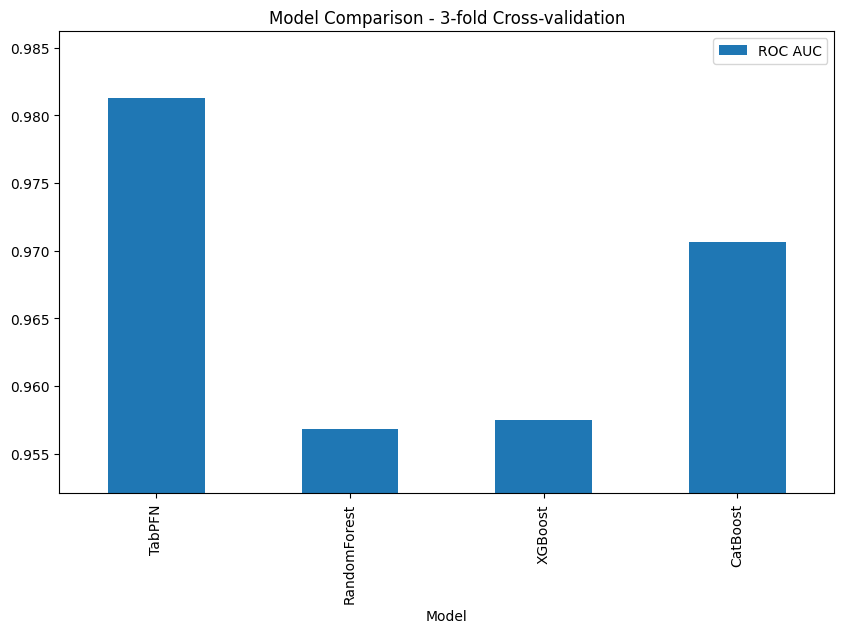

In [ ]:
# Compare different machine learning models by training each one multiple times
# on different parts of the data and averaging their performance scores for a
# more reliable performance estimate

# Encode target labels to classes for baselines
le = LabelEncoder()
y = le.fit_transform(y)

# Define models
models = [
    ("TabPFN", TabPFNClassifier(random_state=42)),
    (
        "RandomForest",
        make_pipeline(
            column_transformer,  # string data needs to be encoded for model
            RandomForestClassifier(random_state=42),
        ),
    ),
    (
        "XGBoost",
        make_pipeline(
            column_transformer,  # string data needs to be encoded for model
            XGBClassifier(random_state=42),
        ),
    ),
    (
        "CatBoost",
        make_pipeline(
            column_transformer,  # string data needs to be encoded for model
            CatBoostClassifier(random_state=42, verbose=0),
        ),
    ),
]

# Calculate scores
n_splits = 3
cv = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)
scoring = "roc_auc_ovr" if len(np.unique(y)) > 2 else "roc_auc"
scores = {
    name: cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=1, verbose=1)
    for name, model in models
}

# Plot results
df = pd.DataFrame(
    [(k, v.mean()) for (k, v) in scores.items()], columns=["Model", "ROC AUC"]
)
ax = df.plot(x="Model", y="ROC AUC", kind="bar", figsize=(10, 6))
ax.set_ylim(df["ROC AUC"].min() * 0.995, min(1.0, df["ROC AUC"].max() * 1.005))
ax.set_title(f"Model Comparison - {n_splits}-fold Cross-validation")

### Auto TabPFN Classifier (Best Predictice Performance)
The AutoTabPFN classifier enhances the standard TabPFN by employing a post-hoc ensemble technique, which is similar to stacking. This method combines predictions from multiple models to improve overall predictive performance. In this section, we'll demonstrate how to use the AutoTabPFN classifier and compare its performance against the standard TabPFN and other baseline models.

In [ ]:
from tabpfn_extensions import AutoTabPFNClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Train and evaluate the TabPFN classifier
tabpfn_classifier = AutoTabPFNClassifier(
    random_state=42,
    eval_metric="roc_auc",  # which metric are we optimizing?
    max_time=60,  # maximum runtime 60 seconds
)
tabpfn_classifier.fit(X_train, y_train)
y_pred_proba = tabpfn_classifier.predict_proba(X_test)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
print(f"TabPFN ROC AUC Score: {roc_auc:.4f}")

tabpfn-v2-classifier-vutqq28w.ckpt:   0%|          | 0.00/12.9M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

KeyboardInterrupt: 

# Regression with TabPFN <a name="regression"></a>

Next, we'll explore how to use TabPFN for regression tasks. We will use the Boston Housing dataset, where the goal is to predict the median value of owner-occupied homes.

We will measure performance using the [Root Mean Squared Error](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.root_mean_squared_error.html), and again, we will compare TabPFN with other popular regression models.

In [ ]:
# Load the Boston Housing dataset
df_boston = fetch_openml(data_id=531, as_frame=True)
X, y = df_boston.data, df_boston.target

# Display the dataset description and data
display(Markdown("### Boston Housing Dataset"))
display(Markdown(df_boston["DESCR"]))
display(X.head())

### Boston Housing Dataset

**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.
Variables in order:
CRIM     per capita crime rate by town
ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS    proportion of non-retail business acres per town
CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX      nitric oxides concentration (parts per 10 million)
RM       average number of rooms per dwelling
AGE      proportion of owner-occupied units built prior to 1940
DIS      weighted distances to five Boston employment centres
RAD      index of accessibility to radial highways
TAX      full-value property-tax rate per $10,000
PTRATIO  pupil-teacher ratio by town
B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
LSTAT    % lower status of the population
MEDV     Median value of owner-occupied homes in $1000's


Information about the dataset
CLASSTYPE: numeric
CLASSINDEX: last

Downloaded from openml.org.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33


In [4]:
from google.colab import files
uploaded = files.upload() # 选择本地文件

Saving EC50-Kikyou_data.xlsx to EC50-Kikyou_data.xlsx



Training Set Metrics:
Mean Squared Error (MSE): 0.34657
Mean Absolute Error (MAE): 0.46195
R-squared (R^2): 0.88052

Validation Set Metrics:
Mean Squared Error (MSE): 1.01566
Mean Absolute Error (MAE): 0.84404
R-squared (R^2): 0.56578


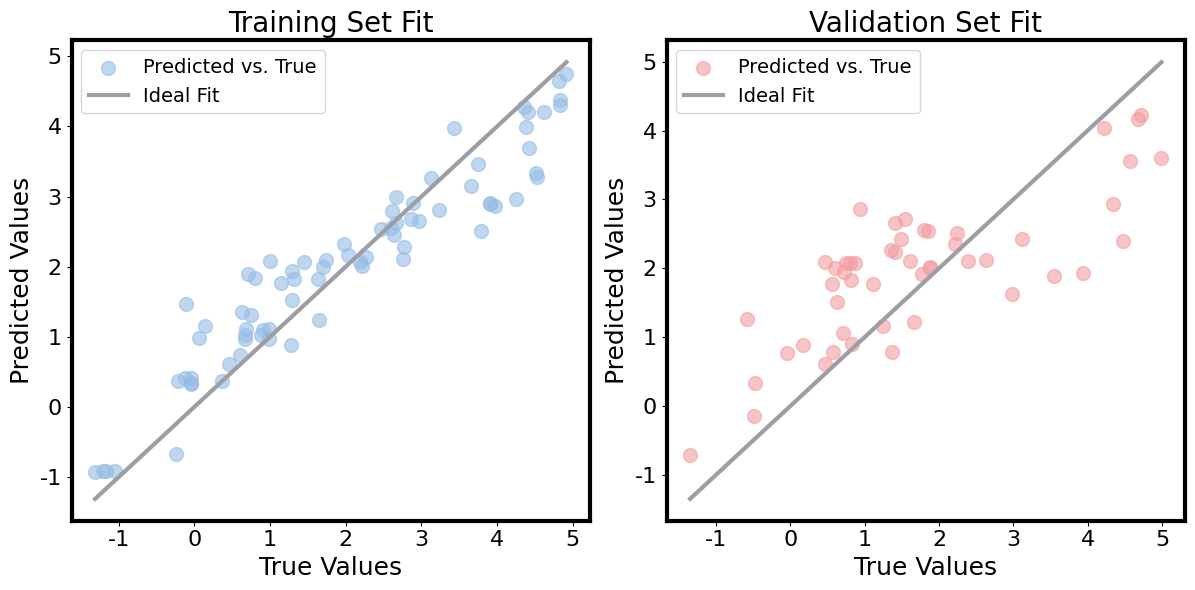

In [23]:
import pandas as pd  # 用于读取 Excel 文件
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  # 用于绘图
from tabpfn import TabPFNRegressor
plt.rcParams['font.family'] = 'DejaVu Sans'
# 加载数据
file_path = r"EC50-Kikyou_data_top30_log.xlsx"  # 单个数据集文件路径

# 读取数据
data = pd.read_excel(file_path, header=0)

# 假设第一列是目标变量，其余列是特征
X = data.iloc[:, 1:]  # 特征数据（所有列除第一列）
y = data.iloc[:, 0]   # 目标变量（第一列）

# 按比例 7：3 划分数据集
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# 初始化 TabPFN 回归器
reg = TabPFNRegressor()
reg.fit(X_train, y_train)  # 使用训练集数据拟合模型

# 在训练集上进行预测并评估
train_predictions = reg.predict(X_train)  # 训练集预测
train_mse = mean_squared_error(y_train, train_predictions)
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

# 在验证集上进行预测并评估
val_predictions = reg.predict(X_val)  # 验证集预测
val_mse = mean_squared_error(y_val, val_predictions)
val_mae = mean_absolute_error(y_val, val_predictions)
val_r2 = r2_score(y_val, val_predictions)

# 打印评估指标
print("\nTraining Set Metrics:")
print(f"Mean Squared Error (MSE): {train_mse:.5f}")
print(f"Mean Absolute Error (MAE): {train_mae:.5f}")
print(f"R-squared (R^2): {train_r2:.5f}")

print("\nValidation Set Metrics:")
print(f"Mean Squared Error (MSE): {val_mse:.5f}")
print(f"Mean Absolute Error (MAE): {val_mae:.5f}")
print(f"R-squared (R^2): {val_r2:.5f}")

# 绘制拟合图：训练集、验证集
plt.figure(figsize=(18, 6), dpi=100)

# 训练集拟合图
plt.subplot(1, 3, 1)
plt.scatter(y_train, train_predictions, alpha=0.6, color='#95bce5', s=100, label='Predicted vs. True')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)],
         color='#9D9EA3', label='Ideal Fit', linewidth=3)
plt.title('Training Set Fit', fontsize=20)
plt.xlabel('True Values', fontsize=18)
plt.ylabel('Predicted Values', fontsize=18)
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=16)
for spine in plt.gca().spines.values():
    spine.set_linewidth(3)

# 验证集拟合图
plt.subplot(1, 3, 2)
plt.scatter(y_val, val_predictions, alpha=0.6, color='#f39da0', s=100, label='Predicted vs. True')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)],
         color='#9D9EA3', label='Ideal Fit', linewidth=3)
plt.title('Validation Set Fit', fontsize=20)
plt.xlabel('True Values', fontsize=18)
plt.ylabel('Predicted Values', fontsize=18)
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=16)
for spine in plt.gca().spines.values():
    spine.set_linewidth(3)

plt.tight_layout()
plt.show()

Per-fold metrics:
Fold 1: Train MSE=0.31940 MAE=0.42258 R2=0.88333 | Val MSE=1.21456 MAE=0.88293 R2=0.46745
Fold 2: Train MSE=0.37791 MAE=0.44711 R2=0.86093 | Val MSE=0.94029 MAE=0.82058 R2=0.62122
Fold 3: Train MSE=0.31657 MAE=0.41924 R2=0.88759 | Val MSE=0.61177 MAE=0.62079 R2=0.60494
Fold 4: Train MSE=0.43042 MAE=0.48939 R2=0.83784 | Val MSE=0.55542 MAE=0.61429 R2=0.80902
Fold 5: Train MSE=0.44196 MAE=0.49902 R2=0.83335 | Val MSE=0.50371 MAE=0.50691 R2=0.82847
Fold 6: Train MSE=0.43484 MAE=0.46558 R2=0.84468 | Val MSE=1.12782 MAE=0.78217 R2=0.25592
Fold 7: Train MSE=0.32305 MAE=0.41064 R2=0.88454 | Val MSE=1.39626 MAE=0.84555 R2=0.06441
Fold 8: Train MSE=0.21282 MAE=0.34953 R2=0.92066 | Val MSE=2.36736 MAE=1.34469 R2=0.05193
Fold 9: Train MSE=0.35984 MAE=0.43898 R2=0.84646 | Val MSE=3.17850 MAE=1.29172 R2=0.36456
Fold 10: Train MSE=0.37462 MAE=0.44906 R2=0.86195 | Val MSE=2.16869 MAE=1.12860 R2=0.07552

Overall (5-fold combined validation) metrics:
MSE=1.38079  MAE=0.87603  R2=0.487

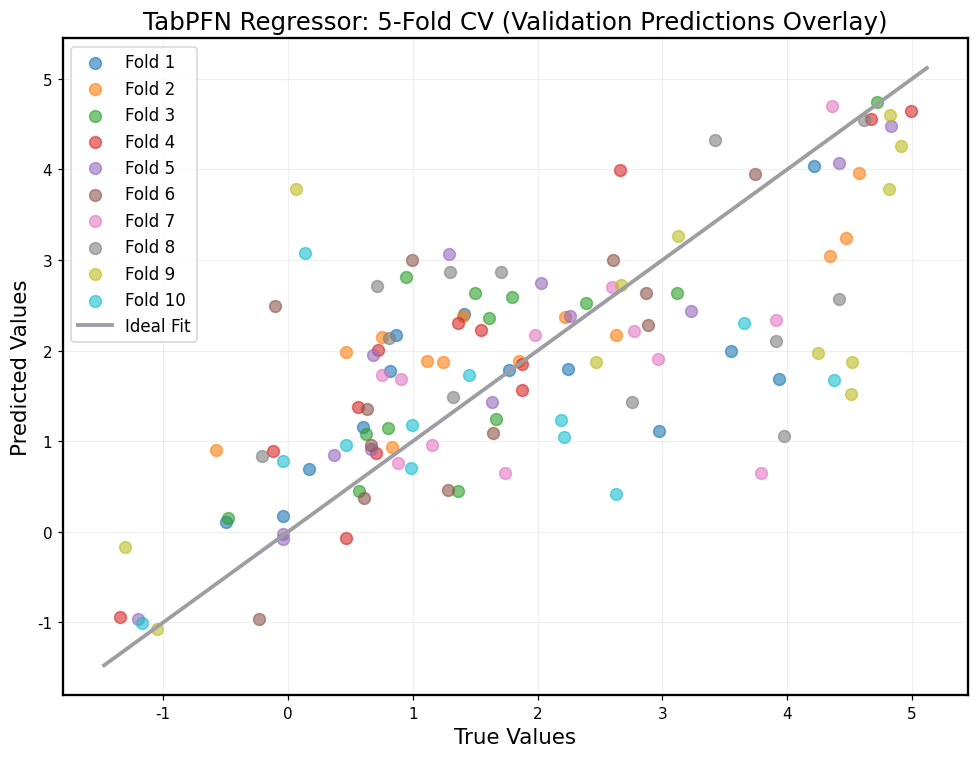

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from tabpfn import TabPFNRegressor

# 可选：避免 GUI 后端问题（如在服务器/远程环境）
# mpl.use("Agg")

# 字体设置（避免 Arial 警告）
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['axes.unicode_minus'] = False

# 1) 读取数据
file_path = r"EC50-Kikyou_data_log.xlsx"
data = pd.read_excel(file_path, header=0)

# 假设第一列是目标，后续列为特征
X = data.iloc[:, 1:].values  # 转为 numpy，避免部分模型对 DataFrame 的警告
y = data.iloc[:, 0].values

# 2) 设备选择
try:
    import torch
    device = "cuda" if torch.cuda.is_available() else "cpu"
except Exception:
    device = "cpu"

# 3) 5 折交叉验证设置
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# 记录各折指标与预测用于最终叠加绘图
fold_metrics = []
all_y_true = []
all_y_pred = []
all_fold_ids = []

# 颜色映射（五折五色）
cmap = plt.get_cmap("tab10")
colors = [cmap(i) for i in range(n_splits)]

# 4) 逐折训练与评估
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), start=1):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # 初始化与训练 TabPFN 回归器
    reg = TabPFNRegressor(device=device)
    reg.fit(X_train, y_train)

    # 训练集预测与指标
    y_pred_train = reg.predict(X_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_r2 = r2_score(y_train, y_pred_train)

    # 验证集预测与指标
    y_pred_val = reg.predict(X_val)
    val_mse = mean_squared_error(y_val, y_pred_val)
    val_mae = mean_absolute_error(y_val, y_pred_val)
    val_r2 = r2_score(y_val, y_pred_val)

    fold_metrics.append({
        "fold": fold,
        "train_mse": train_mse,
        "train_mae": train_mae,
        "train_r2": train_r2,
        "val_mse": val_mse,
        "val_mae": val_mae,
        "val_r2": val_r2,
    })

    # 累积用于叠加图
    all_y_true.append(y_val)
    all_y_pred.append(y_pred_val)
    all_fold_ids.append(np.full_like(y_val, fill_value=fold, dtype=int))

# 合并所有折的预测与标签
all_y_true = np.concatenate(all_y_true, axis=0)
all_y_pred = np.concatenate(all_y_pred, axis=0)
all_fold_ids = np.concatenate(all_fold_ids, axis=0)

# 5) 输出每折指标和整体指标
print("Per-fold metrics:")
for m in fold_metrics:
    print(f"Fold {m['fold']}: "
          f"Train MSE={m['train_mse']:.5f} MAE={m['train_mae']:.5f} R2={m['train_r2']:.5f} | "
          f"Val MSE={m['val_mse']:.5f} MAE={m['val_mae']:.5f} R2={m['val_r2']:.5f}")

# 整体（把五折验证集合并视作整体验证）指标
overall_mse = mean_squared_error(all_y_true, all_y_pred)
overall_mae = mean_absolute_error(all_y_true, all_y_pred)
overall_r2 = r2_score(all_y_true, all_y_pred)

print("\nOverall (5-fold combined validation) metrics:")
print(f"MSE={overall_mse:.5f}  MAE={overall_mae:.5f}  R2={overall_r2:.5f}")

# 6) 绘制五折叠加散点图（验证集）
plt.figure(figsize=(9, 7), dpi=110)

for fold in range(1, n_splits + 1):
    mask = (all_fold_ids == fold)
    plt.scatter(
        all_y_true[mask], all_y_pred[mask],
        alpha=0.6, s=60, color=colors[fold - 1],
        label=f"Fold {fold}"
    )

# 对角线（理想拟合）
y_min = float(np.min(all_y_true))
y_max = float(np.max(all_y_true))
pad = 0.02 * (y_max - y_min + 1e-12)
plt.plot([y_min - pad, y_max + pad], [y_min - pad, y_max + pad],
         color="#9D9EA3", linewidth=2.5, label="Ideal Fit")

plt.title("TabPFN Regressor: 5-Fold CV (Validation Predictions Overlay)", fontsize=16)
plt.xlabel("True Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)
plt.legend(fontsize=11, frameon=True)
plt.grid(alpha=0.2)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

In [12]:
import pandas as pd
import numpy as np

# 读取原始文件
in_path = "EC50-Kikyou_data.xlsx"
out_path = "EC50-Kikyou_data_log.xlsx"

df = pd.read_excel(in_path)

# 安全检查：确保存在名为 "EC50" 的第一列；若第一列不叫 EC50，可按需要调整列名
first_col_name = df.columns[0]
if first_col_name != "EC50":
    raise ValueError(f"第一列列名为 '{first_col_name}'，而非 'EC50'。请确认文件或修改代码中的列名。")

# 对 EC50 列取自然对数，处理非正值
# 非正值（<=0）无法取对数，这里将其设为 NaN；如需其他策略可自行修改
ec50 = pd.to_numeric(df["EC50"], errors="coerce")
ec50_log = np.where(ec50 > 0, np.log(ec50), np.nan)

# 替换列并保存新文件
df["EC50"] = ec50_log
df.to_excel(out_path, index=False)

print(f"已保存：{out_path}")

已保存：EC50-Kikyou_data_log.xlsx


In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder

# 输入输出路径
in_path = "EC50-Kikyou_data.xlsx"
out_path = "EC50-Kikyou_data_top30_log.xlsx"

# 1) 读取
df = pd.read_excel(in_path)

# 基本检查
if df.shape[1] < 2:
    raise ValueError("表格列数不足：至少需要1列目标(EC50) + 1列特征。")

# 2) 目标 ln 变换
target_name = df.columns[0]
if target_name != "EC50":
    print(f"警告：第一列列名为 '{target_name}'，非 'EC50'，将仍以其为目标列处理。")
y_raw = pd.to_numeric(df.iloc[:, 0], errors="coerce")
y_log = np.where(y_raw > 0, np.log(y_raw), np.nan)

# 3) 特征区间（第2列到最后）
X_df = df.iloc[:, 1:].copy()

# 4) 简单数值化：数值列保留，非数值列做 Ordinal 编码
num_cols = X_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_df.columns if c not in num_cols]

X_num = X_df[num_cols].copy()

if cat_cols:
    enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    X_cat = enc.fit_transform(X_df[cat_cols].astype(str))
    X_cat = pd.DataFrame(X_cat, columns=cat_cols, index=X_df.index)
    X_proc = pd.concat([X_num, X_cat], axis=1)
else:
    X_proc = X_num

# 将目标与特征对齐并丢弃含 NaN 的行（必要时）
data_proc = pd.concat([pd.Series(y_log, name="ln_EC50"), X_proc], axis=1)
data_proc = data_proc.dropna(axis=0)

y = data_proc["ln_EC50"].values
X = data_proc.drop(columns=["ln_EC50"])
feature_names = X.columns.tolist()

# 5) 训练随机森林并取特征重要性
# 可调整超参以更稳健，如 n_estimators=500, random_state=42
rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    max_features="sqrt",
)
rf.fit(X, y)
importances = rf.feature_importances_

imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
imp_df = imp_df.sort_values("importance", ascending=False).reset_index(drop=True)

# 6) 选出前30个特征（若不足30，则全用）
top_k = 30
top_features = imp_df["feature"].head(min(top_k, len(imp_df))).tolist()

# 7) 用原始特征数据（未编码版）来构建最终输出表：
#    - 第一列：ln(EC50)（基于清洗后的行）
#    - 后续列：原始特征表中同名列（与 data_proc 的索引对齐后再取）
# 先从原始 df 对齐索引（仅保留 data_proc 的行）
df_aligned = df.loc[data_proc.index].reset_index(drop=True)

# 生成输出表：ln(EC50) + 选中原始特征列（如果某些原始列为非数值，也会直接保留其原值）
out_df = pd.DataFrame({
    "ln_EC50": np.log(pd.to_numeric(df_aligned.iloc[:, 0], errors="coerce"))
})

# 选定的特征列在原始表中可能包含数值或类别，按列名直接取
# 注意：top_features 来自编码后的列名，和原始列名一致（我们保留了原列名）
out_df = pd.concat([out_df, df_aligned[top_features]], axis=1)

# 8) 保存
out_df.to_excel(out_path, index=False)
print(f"已保存前{len(top_features)}特征的新表至：{out_path}")
print("所选特征（按重要性降序）：")
print(top_features)

已保存前30特征的新表至：EC50-Kikyou_data_top30_log.xlsx
所选特征（按重要性降序）：
['qed', 'LabuteASA', 'Chi0', 'Chi0v', 'MolMR', 'AvgIpc', 'BertzCT', 'PEOE_VSA6', 'ExactMolWt', 'MolWt', 'Chi1v', 'BCUT2D_MRHI', 'Ipc', 'Kappa1', 'VSA_EState2', 'Chi4v', 'NumValenceElectrons', 'Chi3v', 'HallKierAlpha', 'Kappa2', 'VSA_EState6', 'PEOE_VSA8', 'Chi2v', 'VSA_EState10', 'Chi0n', 'Chi1', 'MaxAbsEStateIndex', 'Chi1n', 'Chi3n', 'EState_VSA3']


In [21]:
import os, warnings, logging
warnings.filterwarnings("ignore")
logging.getLogger("lightgbm").setLevel(logging.ERROR)

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

# 可选模型
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    from lightgbm import LGBMRegressor
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

from tabpfn import TabPFNRegressor

# 读取与预处理
df = pd.read_excel("EC50-Kikyou_data.xlsx")
y_raw = pd.to_numeric(df.iloc[:, 0], errors="coerce")
y = np.where(y_raw > 0, np.log(y_raw), np.nan)
X_df = df.iloc[:, 1:].apply(pd.to_numeric, errors="coerce")
data = pd.concat([pd.Series(y, name="ln_EC50"), X_df], axis=1).dropna()
y = data.iloc[:, 0].values
X = data.iloc[:, 1:].values

# 基础模型池（简洁）
base_models = {
    "Linear": make_pipeline(StandardScaler(), LinearRegression()),
    "Ridge": make_pipeline(StandardScaler(), Ridge(alpha=1.0, random_state=42)),
    "Lasso": make_pipeline(StandardScaler(), Lasso(alpha=0.001, max_iter=10000, random_state=42)),
    "ElasticNet": make_pipeline(StandardScaler(), ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000, random_state=42)),
    "KNN": make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=7, weights="distance")),
    "SVR": make_pipeline(StandardScaler(), SVR(C=10.0, epsilon=0.1, kernel="rbf")),
    "RF": RandomForestRegressor(n_estimators=600, max_features="sqrt", random_state=42, n_jobs=-1),
    "ET": ExtraTreesRegressor(n_estimators=600, max_features="sqrt", random_state=42, n_jobs=-1),
}
if HAS_XGB:
    base_models["XGB"] = XGBRegressor(
        n_estimators=800, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        random_state=42, n_jobs=-1, verbosity=0  # 静默
    )
if HAS_LGBM:
    base_models["LGBM"] = LGBMRegressor(
        n_estimators=1000, learning_rate=0.03, num_leaves=63,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        random_state=42, n_jobs=-1, verbose=-1  # 静默
    )

# 5 折 OOF
kf = KFold(n_splits=5, shuffle=True, random_state=42)
metrics_per_model = {name: [] for name in base_models}
oof_preds = {name: np.zeros_like(y, dtype=float) for name in base_models}

for tr, va in kf.split(X, y):
    Xtr, Xva = X[tr], X[va]
    ytr, yva = y[tr], y[va]
    for name, model in base_models.items():
        import sklearn.base as skbase
        m = skbase.clone(model)
        m.fit(Xtr, ytr)
        pred = m.predict(Xva)
        oof_preds[name][va] = pred
        metrics_per_model[name].append((
            mean_squared_error(yva, pred),
            mean_absolute_error(yva, pred),
            r2_score(yva, pred)
        ))

print("Base models (5-fold) metrics:")
for name, res in metrics_per_model.items():
    arr = np.array(res)
    print(f"- {name}: MSE {arr[:,0].mean():.4f} | MAE {arr[:,1].mean():.4f} | R2 {arr[:,2].mean():.4f}")

# 元学习器
from sklearn.linear_model import RidgeCV
stack_X = np.column_stack([oof_preds[n] for n in base_models.keys()])
meta = make_pipeline(StandardScaler(), RidgeCV(alphas=np.logspace(-3, 3, 13)))
meta.fit(stack_X, y)
stack_oof = meta.predict(stack_X)

# TabPFN 最终评估（加入 stacking_oof）
try:
    import torch
    device = "cuda" if torch.cuda.is_available() else "cpu"
except Exception:
    device = "cpu"

tab_metrics = []
for tr, va in kf.split(X, y):
    Xtr, Xva = X[tr], X[va]
    ytr, yva = y[tr], y[va]
    # 每折加入对应的 stacking_oof（不泄漏：使用全体 OOF 是安全的）
    Xtr_ext = np.column_stack([Xtr, stack_oof[tr]])
    Xva_ext = np.column_stack([Xva, stack_oof[va]])

    # 标准化（每折内拟合）
    scaler = StandardScaler().fit(Xtr_ext)
    Xtr_s = scaler.transform(Xtr_ext)
    Xva_s = scaler.transform(Xva_ext)

    reg = TabPFNRegressor(device=device)
    reg.fit(Xtr_s, ytr)
    yhat = reg.predict(Xva_s)

    tab_metrics.append((
        mean_squared_error(yva, yhat),
        mean_absolute_error(yva, yhat),
        r2_score(yva, yhat)
    ))

arr = np.array(tab_metrics)
print("\nTabPFN + stacking_oof (5-fold): "
      f"MSE {arr[:,0].mean():.4f} | MAE {arr[:,1].mean():.4f} | R2 {arr[:,2].mean():.4f}")

KeyboardInterrupt: 

In [25]:
import warnings, logging
warnings.filterwarnings("ignore")
logging.getLogger("lightgbm").setLevel(logging.ERROR)

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import clone

# 可选梯度提升
try:
    from lightgbm import LGBMRegressor
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

from tabpfn import TabPFNRegressor

# 1) 读取与目标变换
df = pd.read_excel("EC50-Kikyou_data.xlsx")
y_raw = pd.to_numeric(df.iloc[:, 0], errors="coerce")
y = np.where(y_raw > 0, np.log(y_raw), np.nan)
X_df = df.iloc[:, 1:].apply(pd.to_numeric, errors="coerce")
data = pd.concat([pd.Series(y, name="ln_EC50"), X_df], axis=1).dropna()
y = data.iloc[:, 0].values
X = data.iloc[:, 1:].values

# 2) 预处理器（稳健缩放 + 方差阈值）
# 提示：阈值可调，过大可能丢信息，过小作用不明显
preproc = [
    ("scaler", RobustScaler()),   # 或 QuantileTransformer(output_distribution="normal", subsample=int(1e5))
    ("varth", VarianceThreshold(threshold=0.0))
]

def fit_transform_pipe(Xtr, Xva):
    Xtr_p, Xva_p = Xtr.copy(), Xva.copy()
    fitted = []
    for name, step in preproc:
        step = clone(step)
        Xtr_p = step.fit_transform(Xtr_p)
        Xva_p = step.transform(Xva_p)
        fitted.append((name, step))
    return Xtr_p, Xva_p, fitted

# 3) 精简基础模型池（少而精）
base_models = {
    #"Ridge": make_pipeline(StandardScaler(with_mean=True), Ridge(alpha=1.0, random_state=42)),
    "SVR": make_pipeline(StandardScaler(with_mean=True), SVR(C=10.0, epsilon=0.1, kernel="rbf")),
    "RF": RandomForestRegressor(n_estimators=600, max_features="sqrt", random_state=42, n_jobs=-1),
    "ET": ExtraTreesRegressor(n_estimators=600, max_features="sqrt", random_state=42, n_jobs=-1),
}
if HAS_LGBM:
    base_models["LGBM"] = LGBMRegressor(
        n_estimators=1000, learning_rate=0.03, num_leaves=63,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        random_state=42, n_jobs=-1, verbose=-1
    )

# 4) 5 折 OOF（折内预处理）
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof = {k: np.zeros_like(y, dtype=float) for k in base_models}
metrics = {k: [] for k in base_models}

for tr, va in kf.split(X, y):
    Xtr, Xva = X[tr], X[va]
    ytr, yva = y[tr], y[va]

    # 折内预处理
    Xtr_p, Xva_p, _ = fit_transform_pipe(Xtr, Xva)

    for name, model in base_models.items():
        m = clone(model)
        m.fit(Xtr_p, ytr)
        pred = m.predict(Xva_p)
        oof[name][va] = pred
        metrics[name].append((
            mean_squared_error(yva, pred),
            mean_absolute_error(yva, pred),
            r2_score(yva, pred)
        ))

print("Base models (5-fold mean):")
for name, res in metrics.items():
    arr = np.array(res)
    print(f"- {name}: MSE {arr[:,0].mean():.4f} | MAE {arr[:,1].mean():.4f} | R2 {arr[:,2].mean():.4f}")

# 5) 构造多列 OOF 特征 + 简单平均列
oof_matrix = np.column_stack([oof[n] for n in base_models.keys()])
oof_names = [f"oof_{n}" for n in base_models.keys()]
oof_mean = oof_matrix.mean(axis=1, keepdims=True)
X_oof_ext = np.hstack([X, oof_matrix, oof_mean])
ext_names = list(data.columns[1:]) + oof_names + ["oof_mean"]

# 6) TabPFN 评估：对比 原始特征 vs. 加多列 OOF
try:
    import torch
    device = "cuda" if torch.cuda.is_available() else "cpu"
except Exception:
    device = "cpu"

def eval_tabpfn(Xfeat, desc):
    scores = []
    for tr, va in kf.split(Xfeat, y):
        Xtr, Xva = Xfeat[tr], Xfeat[va]
        ytr, yva = y[tr], y[va]
        # 折内再次做一个标准化即可（TabPFN通常不敏感，但有助稳定）
        scaler = StandardScaler().fit(Xtr)
        Xtr_s = scaler.transform(Xtr)
        Xva_s = scaler.transform(Xva)
        reg = TabPFNRegressor(device=device)
        reg.fit(Xtr_s, ytr)
        pred = reg.predict(Xva_s)
        scores.append((
            mean_squared_error(yva, pred),
            mean_absolute_error(yva, pred),
            r2_score(yva, pred)
        ))
    arr = np.array(scores)
    print(f"{desc}: MSE {arr[:,0].mean():.4f} | MAE {arr[:,1].mean():.4f} | R2 {arr[:,2].mean():.4f}")

eval_tabpfn(X, "TabPFN baseline")
eval_tabpfn(X_oof_ext, "TabPFN + OOF columns + OOF mean")

Base models (5-fold mean):
- SVR: MSE 1.4695 | MAE 0.9436 | R2 0.4185
- RF: MSE 1.5408 | MAE 0.9564 | R2 0.4036
- ET: MSE 1.5029 | MAE 0.9153 | R2 0.4067
- LGBM: MSE 1.7343 | MAE 1.0094 | R2 0.3241
TabPFN baseline: MSE 1.3977 | MAE 0.8873 | R2 0.4495
TabPFN + OOF columns + OOF mean: MSE 1.5354 | MAE 0.9604 | R2 0.4066


In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# Train and evaluate the TabPFN regressor
tabpfn_regressor = TabPFNRegressor(random_state=42)
tabpfn_regressor.fit(X_train, y_train)
y_pred = tabpfn_regressor.predict(X_test)

# Calculate the Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"TabPFN RMSE: {rmse:.4f}")

tabpfn-v2-regressor.ckpt:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

TabPFN RMSE: 2.5910


### Auto TabPFN Regressor (Best Predictice Performance)
The AutoTabPFN regressor enhances the standard TabPFN by employing a post-hoc ensemble technique, which is similar to stacking. This method combines predictions from multiple models to improve overall predictive performance. In this section, we'll demonstrate how to use the AutoTabPFN regressor and compare its performance against the standard TabPFN and other baseline models.

In [ ]:
from tabpfn_extensions import AutoTabPFNRegressor

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# Train and evaluate the TabPFN regressor
tabpfn_regressor = AutoTabPFNRegressor(
    random_state=42,
    eval_metric="rmse",  # which metric are we optimizing?
    max_time=60,  # maximum runtime 60 seconds
)
tabpfn_regressor.fit(X_train, y_train)
y_pred = tabpfn_regressor.predict(X_test)

# Calculate the Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"TabPFN RMSE: {rmse:.4f}")

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
Memory Avail:       9.34 GB / 12.67 GB (73.7%)
Disk Space Avail:   73.63 GB / 112.64 GB (65.4%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='extreme' : New in v1.4: Massively better than 'best' on datasets <30000 samples by using new models meta-learned on https://tabarena.ai: TabPFNv2, TabICL, Mitra, and TabM. Absolute best accuracy. Requires a GPU. Recommended 64 GB CPU memory and 32+ GB GPU memory.
	presets='best'    : Maximize accuracy. Recommended for most users. Use in c

TabPFN RMSE: 2.4910


### Comparing TabPFN with Other Regressors

Now, let's see how TabPFN's regression performance stacks up against other models using cross-validation.


In [ ]:
# Compare different machine learning models by training each one multiple times
# on different parts of the data and averaging their performance scores for a
# more reliable performance estimate

# Define models
models = [
    ("TabPFN", TabPFNRegressor(random_state=42)),
    (
        "RandomForest",
        make_pipeline(
            column_transformer,  # string data needs to be encoded for model
            RandomForestRegressor(random_state=42),
        ),
    ),
    (
        "XGBoost",
        make_pipeline(
            column_transformer,  # string data needs to be encoded for model
            XGBRegressor(random_state=42),
        ),
    ),
    (
        "CatBoost",
        make_pipeline(
            column_transformer,  # string data needs to be encoded for model
            CatBoostRegressor(random_state=42, verbose=0),
        ),
    ),
]

# Calculate scores
scoring = "r2"
n_splits = 3
cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)
scores = {
    name: cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=1, verbose=1)
    for name, model in models
}


# Plot results
df = pd.DataFrame([(k, v.mean()) for (k, v) in scores.items()], columns=["Model", "R2"])
ax = df.plot(x="Model", y="R2", kind="bar", figsize=(10, 6))
ax.set_ylim(df["R2"].min() * 0.99, df["R2"].max() * 1.01)
ax.set_title(
    f"Model Comparison - {n_splits}-fold Cross-validation \n (Variance Explained - Larger is better)"
)

# Handling Text Data <a name="text-data"></a>

A powerful feature of the TabPFN server is its ability to handle text data directly, without the need for manual feature engineering. This simplifies the process of working with datasets that contain a mix of numerical and textual features.

**Note:** This feature is only available when using the 'client' backend.

In [ ]:
if backend != "client":
    console.print(
        Panel(
            "[bold yellow]Text data can only be processed through the TabPFN server. Please restart the notebook and select the 'client' backend to run this section.[/bold yellow]",
            title="[bold yellow]Warning",
            border_style="yellow",
        )
    )
else:
    # We will use gdown to download the dataset
    !gdown --fuzzy "17bJekFGIAxbrdcBeBIvcyZjneweY581E"

    # Load the clothing review dataset
    # We restrict to 500 rows to make the example faster
    df_text = pd.read_csv("cloth.csv", index_col=0).dropna()[:500]

    # Define features and target
    y_text = df_text["Rating"]
    X_text = df_text.drop(columns=["Rating"])

    print("Text dataset loaded successfully!")
    display(X_text.head())

╭──────────────────────────────────────────────────── Warning ────────────────────────────────────────────────────╮
│ Text data can only be processed through the TabPFN server. Please restart the notebook and select the 'client'  │
│ backend to run this section.                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

### Comparing Text Handling

Now, let's compare how TabPFN handles text natively versus how a baseline model like RandomForest needs a specific text processing pipeline.

For baselines, we will create a pipeline that converts strings to ordinal features.

For TabPFN, we simply pass the raw data with the text column directly to the classifier.

In [ ]:
if backend == "client":
    # Encode target labels to classes for baselines
    le = LabelEncoder()
    y_text = le.fit_transform(y_text)

    # Define models
    models = [
        ("TabPFN-Text", TabPFNClassifier(random_state=42)),
        (
            "TabPFN",
            make_pipeline(
                column_transformer,  # string data needs to be encoded for model
                TabPFNClassifier(random_state=42),
            ),
        ),
        (
            "RandomForest",
            make_pipeline(
                column_transformer,  # string data needs to be encoded for model
                RandomForestClassifier(random_state=42),
            ),
        ),
        (
            "XGBoost",
            make_pipeline(
                column_transformer,  # string data needs to be encoded for model
                XGBClassifier(random_state=42),
            ),
        ),
        (
            "CatBoost",
            make_pipeline(
                column_transformer,  # string data needs to be encoded for model
                CatBoostClassifier(random_state=42, verbose=0),
            ),
        ),
    ]

    # Calculate scores
    cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
    scoring = "roc_auc_ovr" if len(np.unique(y_text)) > 2 else "roc_auc"
    scores = {
        name: cross_val_score(
            model, X_text, y_text, cv=cv, scoring=scoring, n_jobs=1, verbose=1
        ).mean()
        for name, model in models
    }

    # Plot results
    df = pd.DataFrame(list(scores.items()), columns=["Model", "ROC AUC"])
    ax = df.plot(x="Model", y="ROC AUC", kind="bar", figsize=(10, 6))
    ax.set_ylim(df["ROC AUC"].min() * 0.995, min(1.0, df["ROC AUC"].max() * 1.005))
    ax.set_title("Model Comparison - 5-fold Cross-validation")

# Unsupervised Learning with TabPFN <a name="unsupervised-learning"></a>

TabPFN can also be used for unsupervised learning tasks like outlier detection and synthetic data generation. These features are available through the `tabpfn-extensions` library.


### Data Generation

100%|██████████| 3/3 [00:10<00:00,  3.50s/it]


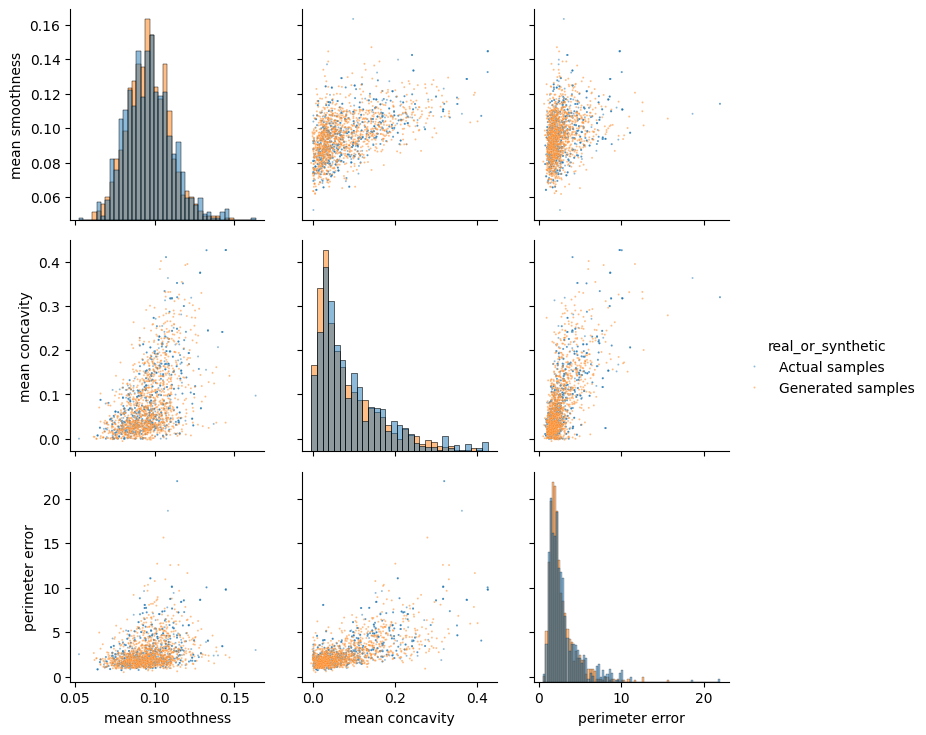

In [ ]:
from tabpfn_extensions import unsupervised
from tabpfn_extensions.unsupervised import experiments

# Load and prepare breast cancer dataset
df = load_breast_cancer(return_X_y=False)
X, y = df["data"], df["target"]
feature_names = df["feature_names"]

# Initialize TabPFN models
model_unsupervised = unsupervised.TabPFNUnsupervisedModel(
    tabpfn_clf=TabPFNClassifier(), tabpfn_reg=TabPFNRegressor()
)

# Select features for synthetic data generation
# Example features: [mean texture, mean area, mean concavity]
feature_indices = [4, 6, 12]

# Run synthetic data generation experiment
experiment = unsupervised.experiments.GenerateSyntheticDataExperiment(
    task_type="unsupervised"
)

results = experiment.run(
    tabpfn=model_unsupervised,
    X=torch.tensor(X),
    y=torch.tensor(y),
    attribute_names=feature_names,
    temp=1.0,  # Temperature parameter for sampling
    n_samples=X.shape[0] * 2,  # Generate twice as many samples as original data
    indices=feature_indices,
)

### Outlier detection

tabpfn-v2-regressor.ckpt:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

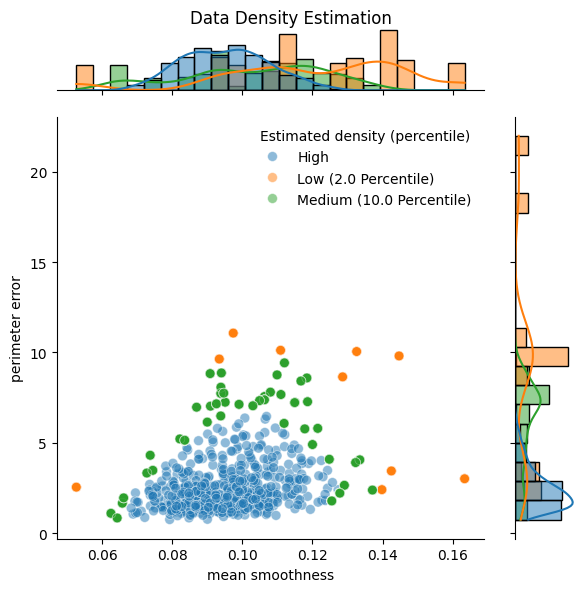

In [ ]:
import torch
from sklearn.datasets import load_breast_cancer
from tabpfn_extensions import unsupervised
from tabpfn_extensions.unsupervised import experiments

# Load data
df = load_breast_cancer(return_X_y=False)
X, y = df["data"], df["target"]
attribute_names = df["feature_names"]

# Initialize models
clf = TabPFNClassifier(n_estimators=4)
reg = TabPFNRegressor(n_estimators=4)
model_unsupervised = unsupervised.TabPFNUnsupervisedModel(
    tabpfn_clf=clf, tabpfn_reg=reg
)

# Run outlier detection
exp_outlier = unsupervised.experiments.OutlierDetectionUnsupervisedExperiment(
    task_type="unsupervised"
)
results = exp_outlier.run(
    tabpfn=model_unsupervised,
    X=torch.tensor(X, dtype=torch.float32),
    y=torch.tensor(y),
    attribute_names=attribute_names,
    indices=[4, 12],  # Analyze features 4 and 12
)

### Missing value imputation

In [ ]:
# --- 1. Load and Prepare Data ---
# Load the breast cancer dataset
df = load_breast_cancer(return_X_y=False)
X, y = df["data"], df["target"]

# Split the data into training and testing sets
X_train, X_test = train_test_split(
    X,
    test_size=0.33,
    random_state=42,
)

# --- 2. Introduce Missing Values ---
# Create a copy of the test set to introduce missing values (NaNs)
X_test_missing = X_test.copy()
n_samples, n_features = X_test_missing.shape

# Introduce missing values in the first three columns for demonstration
missing_fraction = 0.3
n_missing = int(n_samples * missing_fraction)

for col_idx in range(3):
    # Choose random rows to set to NaN
    missing_indices = np.random.choice(n_samples, n_missing, replace=False)
    X_test_missing[missing_indices, col_idx] = np.nan

print(f"Introduced {np.isnan(X_test_missing).sum()} missing values into the test set.")
print(pd.DataFrame(X_test_missing[:, 0:3]).head())

# --- 3. Initialize the Unsupervised Model ---
# Initialize TabPFN models for regression and classification tasks.
# The unsupervised model uses these to model the data distribution.
clf = TabPFNClassifier(n_estimators=3)
reg = TabPFNRegressor(n_estimators=3)

# Initialize the main unsupervised model
model_unsupervised = unsupervised.TabPFNUnsupervisedModel(
    tabpfn_clf=clf,
    tabpfn_reg=reg,
)

# --- 4. Fit and Impute ---
# Fit the model on the complete training data (without missing values)
print("Fitting the unsupervised model on the training data...")
model_unsupervised.fit(X_train)

# Perform imputation on the test set
print("Imputing missing values...\n")
X_imputed_tensor = model_unsupervised.impute(
    X_test_missing,
    n_permutations=5,  # Fewer permutations for a quicker example
)

print("\n------------------------")

# --- 5. Verify Results ---
# Check that the imputed data no longer contains any NaN values
n_missing_after = torch.isnan(X_imputed_tensor).sum().item()

print(f"\nNumber of missing values after imputation: {n_missing_after}")
print(pd.DataFrame(X_imputed_tensor[:, 0:3]).head())

# Optional: Calculate the Mean Squared Error for the imputed values,
# since we know the original ground truth values.
original_nan_mask = np.isnan(X_test_missing)
imputed_values = X_imputed_tensor.numpy()[original_nan_mask]
original_values = X_test[original_nan_mask]

mse = np.mean((imputed_values - original_values) ** 2)
print(f"Mean Squared Error of imputed values vs. original values: {mse:.4f}")

Introduced 168 missing values into the test set.
       0      1       2
0  12.47    NaN     NaN
1  18.94    NaN  123.60
2  15.46  19.48  101.70
3  12.40    NaN   81.47
4    NaN  14.44     NaN
Fitting the unsupervised model on the training data...
Imputing missing values...



100%|██████████| 3/3 [00:14<00:00,  4.80s/it]


------------------------

Number of missing values after imputation: 0
           0          1           2
0  12.470000  17.803307   80.969009
1  18.940001  20.984118  123.599998
2  15.460000  19.480000  101.699997
3  12.400000  17.807310   81.470001
4  11.793373  14.440000   75.049889
Mean Squared Error of imputed values vs. original values: 3.0153


# Model Interpretability <a name="interpretability"></a>

Understanding *why* a model makes certain predictions is crucial for building trust and for debugging. The `tabpfn-extensions` library provides tools for model interpretability. We'll look at SHAP (SHapley Additive exPlanations) values, which show the impact of each feature on a specific prediction.

### Shapley Values

Next, we'll use SHAP to understand our model's predictions. SHAP values break down a prediction to show the contribution of each feature, helping us see which factors are most influential for a given data point.


PermutationExplainer explainer: 51it [03:00,  3.69s/it]


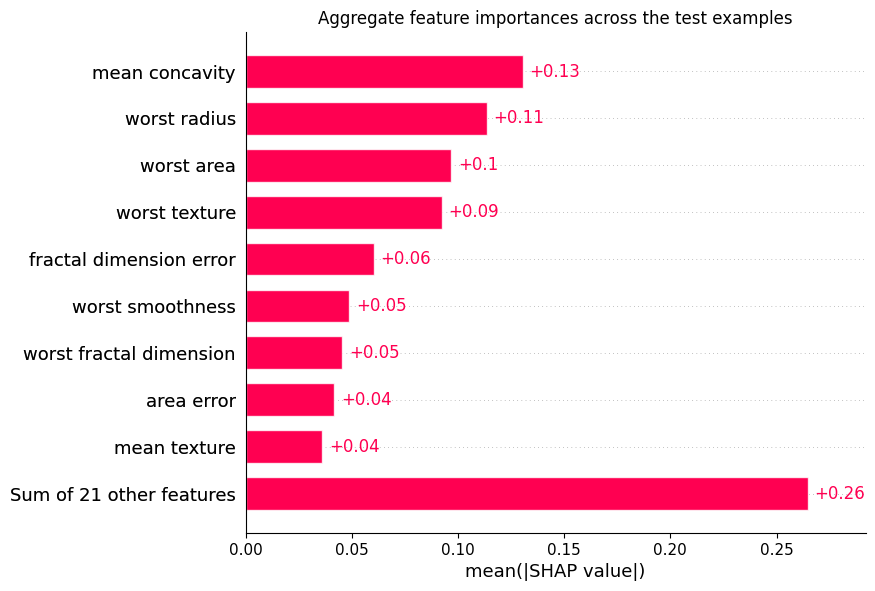

/content/tabpfn-extensions/src/tabpfn_extensions/interpretability/shap.py:134: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values=shap_values, show=False)


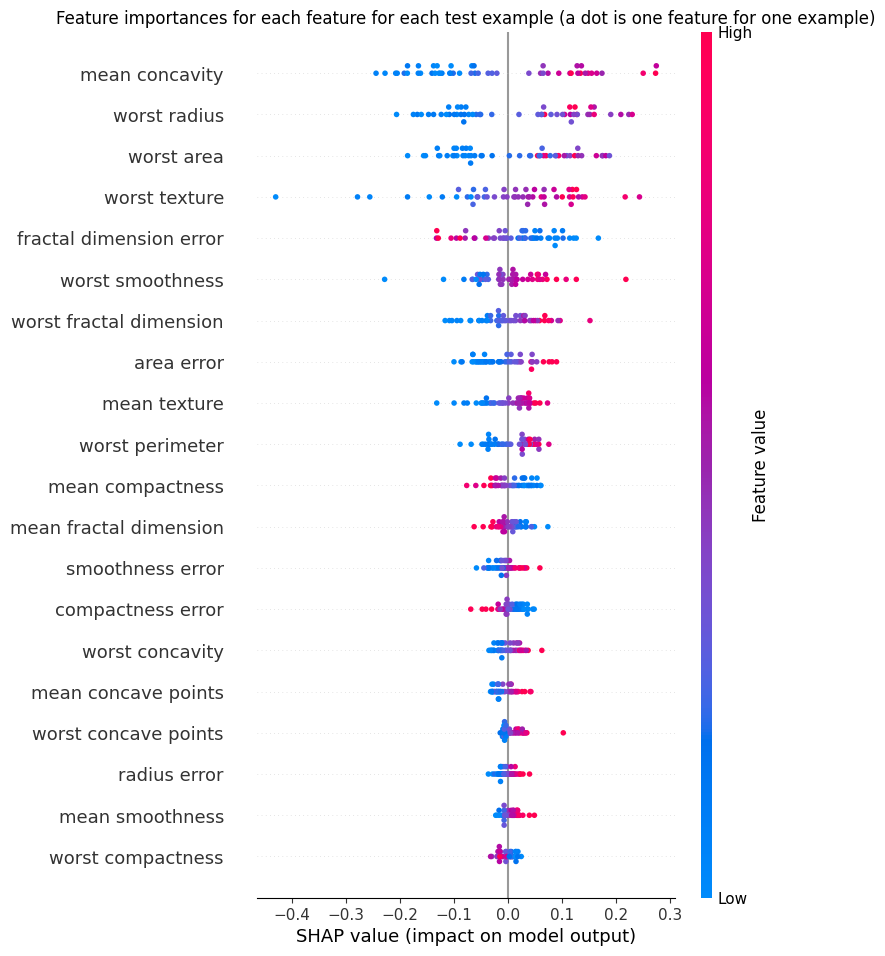

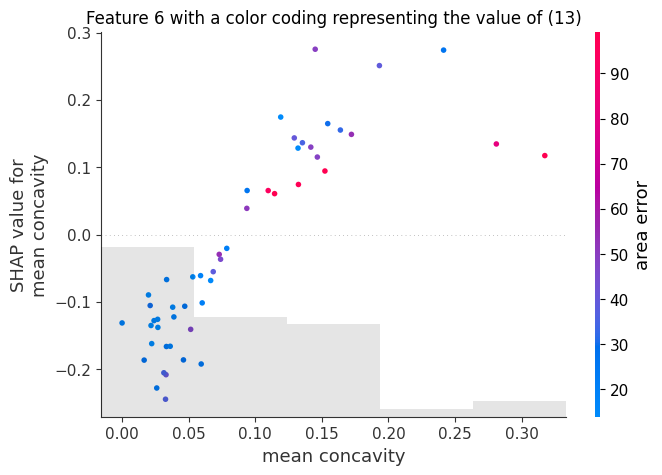

In [ ]:
from tabpfn_extensions import interpretability

# Load example dataset
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names
n_samples = 50

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Initialize and train model
clf = TabPFNClassifier()
clf.fit(X_train, y_train)

# Calculate SHAP values
shap_values = interpretability.shap.get_shap_values(
    estimator=clf,
    test_x=X_test[:n_samples],
    attribute_names=feature_names,
    algorithm="permutation",
)

# Create visualization
fig = interpretability.shap.plot_shap(shap_values)

### Embeddings

This example demonstrates how to extract embeddings from TabPFN models and use them
for classification and regression tasks.

NOTE: This example requires the full TabPFN implementation (pip install tabpfn).
It will not work with the TabPFN client (pip install tabpfn-client) because
the embedding functionality is not available in the client version.


Loading classification dataset (breast cancer)...
Baseline Logistic Regression Accuracy: 0.9614
Logistic Regression with TabPFN (Vanilla) Accuracy: 0.9825

Applying t-SNE for visualization on the TEST SET only...


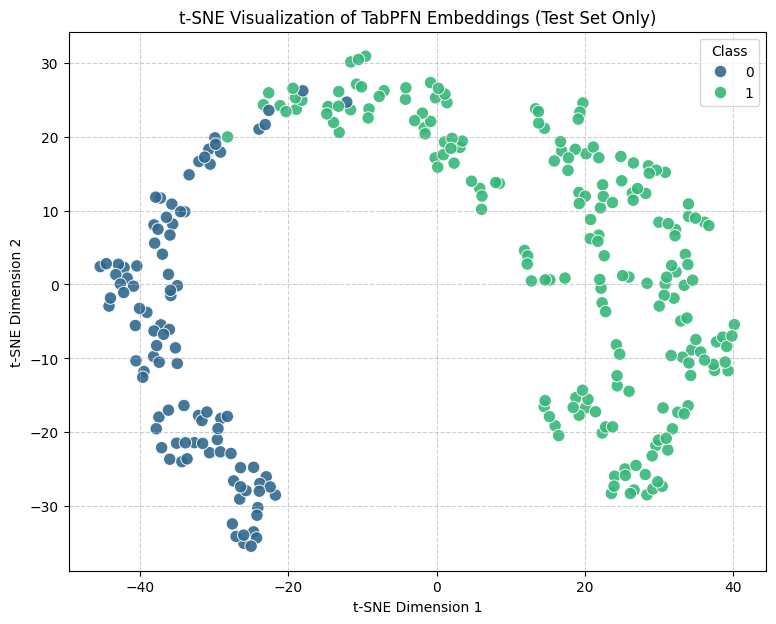

In [ ]:
if backend == "client":
    console.print(
        Panel(
            "[bold yellow]Text data can only be processed through the TabPFN server. Please restart the notebook and select the 'client' backend to run this section.[/bold yellow]",
            title="[bold yellow]Warning",
            border_style="yellow",
        )
    )
else:
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import seaborn as sns
    from sklearn.datasets import load_breast_cancer, load_diabetes
    from sklearn.linear_model import LinearRegression, LogisticRegression
    from sklearn.manifold import TSNE
    from sklearn.metrics import accuracy_score, r2_score
    from sklearn.model_selection import train_test_split
    from tabpfn_extensions import TabPFNClassifier, TabPFNRegressor
    from tabpfn_extensions.embedding import TabPFNEmbedding

    # Load and evaluate classification dataset
    print("Loading classification dataset (breast cancer)...")
    df = load_breast_cancer(return_X_y=False)
    X, y = df["data"], df["target"]
    attribute_names = df["feature_names"]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.5,
        random_state=42,
    )

    # Train and evaluate vanilla logistic regression
    model = LogisticRegression(
        max_iter=10000,
        random_state=42,
    )
    model.fit(X_train, y_train)
    print(
        f"Baseline Logistic Regression Accuracy: {accuracy_score(y_test, model.predict(X_test)):.4f}",
    )

    # Train and evaluate TabPFN embeddings (vanilla)
    clf = TabPFNClassifier(n_estimators=1, random_state=42)
    embedding_extractor = TabPFNEmbedding(tabpfn_clf=clf, n_fold=0)
    train_embeddings = embedding_extractor.get_embeddings(
        X_train,
        y_train,
        X_test,
        data_source="train",
    )
    test_embeddings = embedding_extractor.get_embeddings(
        X_train,
        y_train,
        X_test,
        data_source="test",
    )

    model = LogisticRegression(
        max_iter=10000,
        random_state=42,
    )
    model.fit(train_embeddings[0], y_train)
    y_pred = model.predict(test_embeddings[0])
    print(
        f"Logistic Regression with TabPFN (Vanilla) Accuracy: {accuracy_score(y_test, y_pred):.4f}",
    )

    # Note: Using test_embeddings and y_test from your original script.
    # The embeddings have shape (n_splits, n_samples, n_features), so we use the first split [0].
    test_only_embeddings = test_embeddings[0]

    # Apply t-SNE to reduce the TEST embeddings to 2 dimensions.
    # The number of samples in the test set is len(y_test). Perplexity must be less than that.
    # We'll set perplexity to 30, which is suitable for this dataset size.
    print("\nApplying t-SNE for visualization on the TEST SET only...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=10)
    embeddings_2d = tsne.fit_transform(test_only_embeddings)

    # Create a DataFrame for easy plotting
    df_plot = pd.DataFrame(
        {
            "t-SNE-1": embeddings_2d[:, 0],
            "t-SNE-2": embeddings_2d[:, 1],
            "label": y_test,
        }
    )

    # Plot the 2D embeddings for the test set
    plt.figure(figsize=(9, 7))
    sns.scatterplot(
        data=df_plot,
        x="t-SNE-1",
        y="t-SNE-2",
        hue="label",  # Color points by their class label
        palette="viridis",
        alpha=0.9,
        s=80,
    )

    plt.title("t-SNE Visualization of TabPFN Embeddings (Test Set Only)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend(title="Class")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

### Feature selection

Feature selection is the process of selecting a subset of relevant features for use in model construction. It's useful for reducing model complexity, improving performance by removing noise, and decreasing training time. Here, we'll use Sequential Forward Selection (SFS), which starts with no features and iteratively adds the feature that most improves the model's performance.

The goal is to see if we can create a simpler, faster model with fewer features without a significant drop in accuracy.


In [ ]:
from tabpfn_extensions import interpretability

# Load data
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names

# Initialize model
clf = TabPFNClassifier(n_estimators=1)

# Feature selection
sfs = interpretability.feature_selection.feature_selection(
    estimator=clf, X=X, y=y, n_features_to_select=4, feature_names=feature_names
)

# Print selected features
selected_features = [
    feature_names[i] for i in range(len(feature_names)) if sfs.get_support()[i]
]
print("\nSelected features:")
for feature in selected_features:
    print(f"- {feature}")


Selected features:
- mean texture
- mean concavity
- worst perimeter
- worst smoothness


# Predictive Behavior of TabPFN <a name="behavior"></a>

In this section, we explore the behavior of predictions from TabPFN on various toy functions.

## Decision Boundary during Classification

First, let us inspect the decision boundary for different classifiers.
The decision bounds show how smoothly a model learns to transition between classes and how well it fits the data.

In the first cell, we create the data and code to plot the decision boundary. The second cell then generates the plot.

In [ ]:
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay


# Toy functions that generate the data
def generate_circle(n_datapoints, radius, noise_factor):
    angles = np.linspace(0, 2 * np.pi, n_datapoints).T
    x = radius * np.cos(angles) + np.random.randn(n_datapoints) * noise_factor
    y = radius * np.sin(angles) + np.random.randn(n_datapoints) * noise_factor

    return np.stack([x, y]).T


def generate_concentric_cirlces(radii, num_points_per_circle, noise_factor=1 / 15):
    circles = []
    for r, num_points in zip(radii, num_points_per_circle):
        circles.append(generate_circle(num_points, r, noise_factor))

    return np.vstack(circles)


def generate_circle_data(num_points_per_circle, radii, noise_factor):
    radii = np.array(radii)
    circles_1 = generate_concentric_cirlces(radii, num_points_per_circle, noise_factor)
    circles_1 = np.hstack([circles_1, np.zeros((sum(num_points_per_circle), 1))])

    circles_2 = generate_concentric_cirlces(
        radii + 0.3, num_points_per_circle, noise_factor
    )
    circles_2 = np.hstack([circles_2, np.ones((sum(num_points_per_circle), 1))])

    circles = np.vstack([circles_1, circles_2])
    X, y = circles[:, :2], circles[:, 2]
    return X, y


# Generate the data
X_train, y_train = generate_circle_data(
    num_points_per_circle=[50, 100, 200], radii=[1, 2, 4], noise_factor=0.1
)


# Function for plotting
def plot_decision_boundary(ax, model, model_name):
    cmap = ListedColormap(["#FF0000", "#0000FF"])
    ax.set_title(model_name)
    DecisionBoundaryDisplay.from_estimator(
        model,
        X_train[:, :2],
        alpha=0.6,
        ax=ax,
        eps=0.2,
        grid_resolution=50,
        response_method="predict_proba",
        cmap=plt.cm.RdBu,
    )
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train > 0, cmap=cmap)

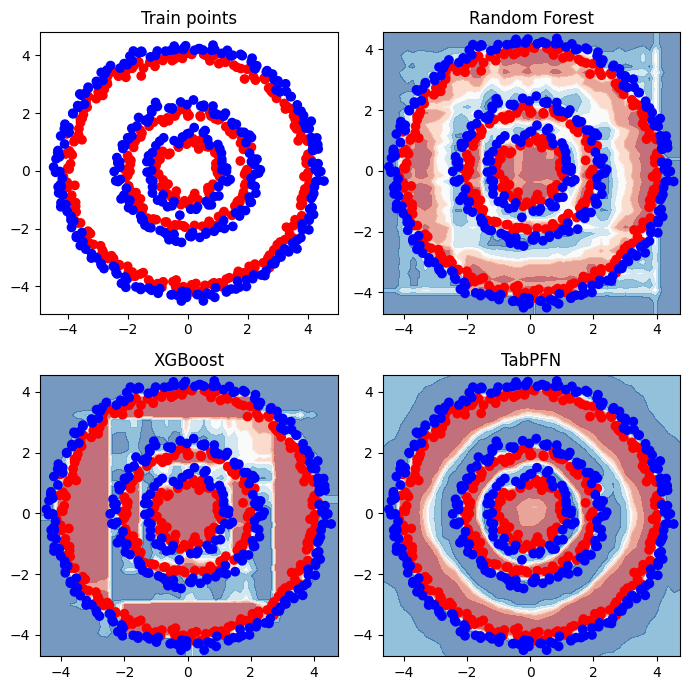

In [ ]:
rf = RandomForestClassifier().fit(X_train[:, :2], y_train)
xgb = XGBClassifier().fit(X_train[:, :2], y_train)
tabpfn = TabPFNClassifier().fit(X_train[:, :2], y_train)

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(7, 7))

# Plot Train Points
ax_points = axes[0, 0]
ax_points.set_title("Train points")
ax_points.scatter(
    X_train[:, 0], X_train[:, 1], c=y_train, cmap=ListedColormap(["#FF0000", "#0000FF"])
)

# Plot Random Forest
ax_rf = axes[0, 1]
plot_decision_boundary(ax_rf, rf, "Random Forest")

# Plot XGBoost
ax_xgb = axes[1, 0]
plot_decision_boundary(ax_xgb, xgb, "XGBoost")

# Plot TabPFN
ax_tabpfn = axes[1, 1]
plot_decision_boundary(ax_tabpfn, tabpfn, "TabPFN")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Sin Curve Fitting with Regression

Next, we investigate the curve-fitting behavior of the different models on a sin curve.

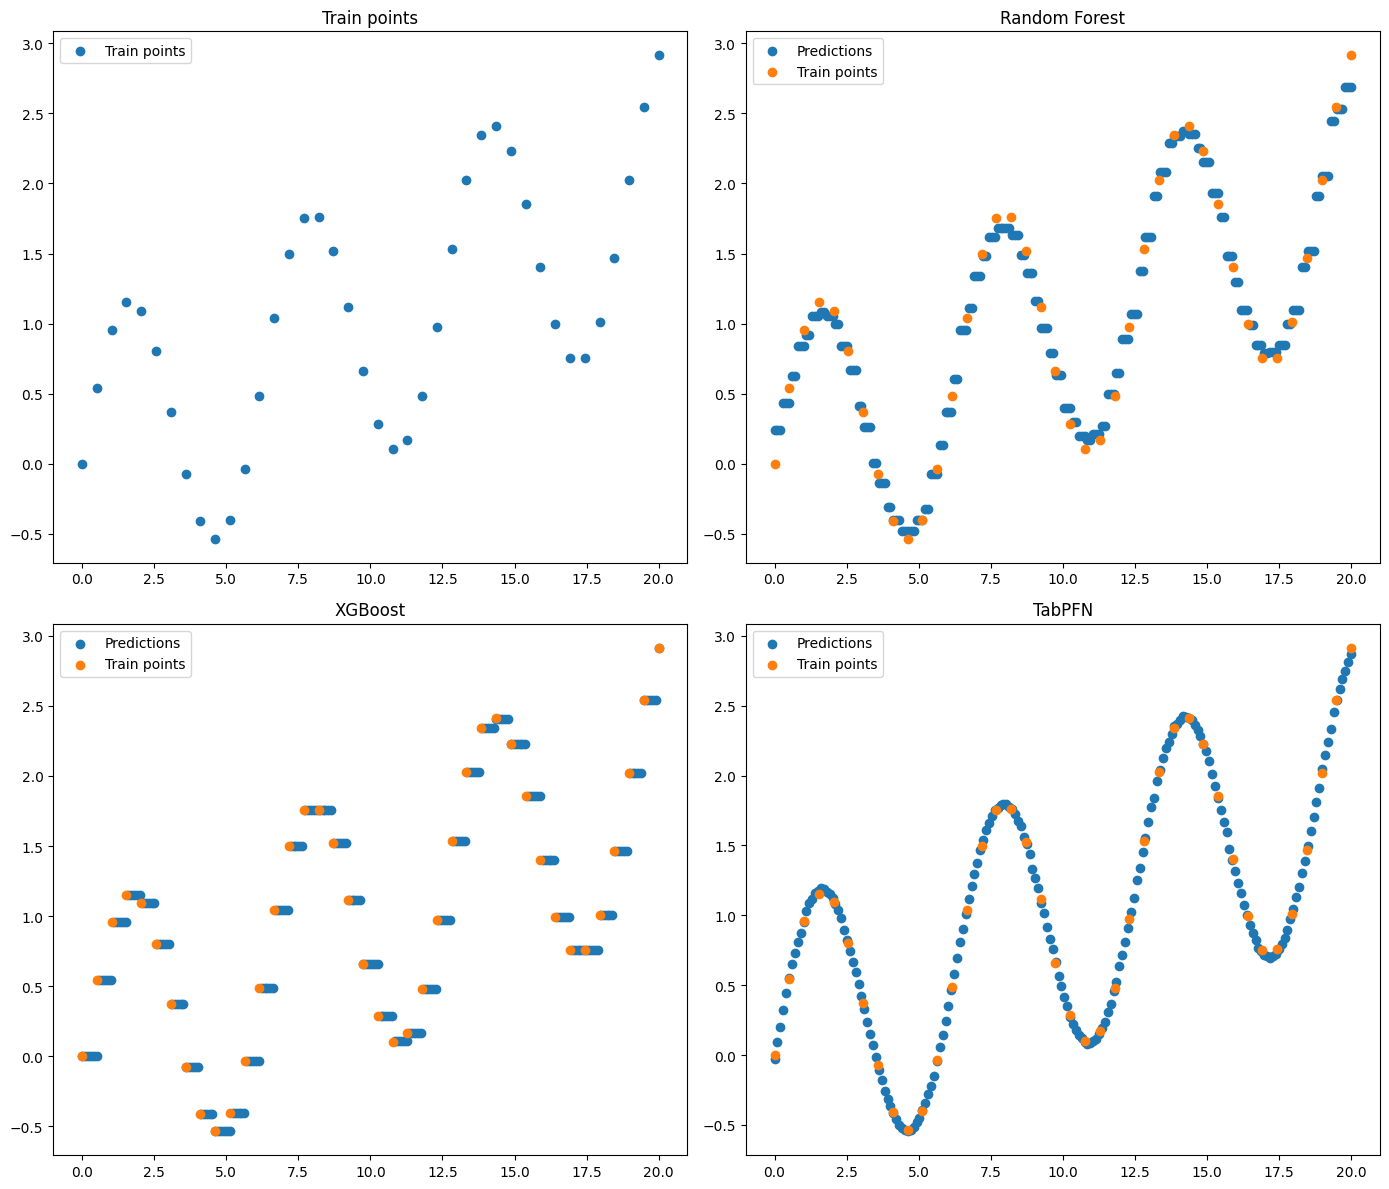

In [ ]:
# Toy function to generate data
def generate_sinx_plus_x(N):
    x = np.linspace(0, 20, N)
    y = np.sin(x) + x / 10

    return x.reshape(-1, 1), y


# Utility function for plotting
def plot_predictions(ax, model, model_name):
    X_test = np.linspace(0, 20, 200).reshape(
        -1, 1
    )  # Predict for 200 points  between 0 and 20
    y_preds = model.predict(X_test)
    ax.set_title(model_name)
    ax.scatter(X_test, y_preds, label="Predictions")
    ax.scatter(X_train, y_train, label="Train points")
    ax.legend()


# Generate data
X_train, y_train = generate_sinx_plus_x(N=40)

# Fit Models
rf = RandomForestRegressor(random_state=42).fit(X_train, y_train)
xgb = XGBRegressor(random_state=42).fit(X_train, y_train)
tabpfn = TabPFNRegressor()
tabpfn.fit(X_train, y_train)

# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Plot train points
ax_points = axs[0, 0]
ax_points.set_title("Train points")
ax_points.scatter(X_train, y_train, label="Train points")
ax_points.legend()

# Plot predictions for Random Forest
ax_rf = axs[0, 1]
plot_predictions(ax_rf, rf, "Random Forest")

# Plot predictions for XGBoost
ax_xgb = axs[1, 0]
plot_predictions(ax_xgb, xgb, "XGBoost")

# Plot predictions for TabPFN
ax_tabpfn = axs[1, 1]
plot_predictions(ax_tabpfn, tabpfn, "TabPFN")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Uncertainty of TabPFN / Quantile Regresison

---



TabPFN is trained to predict the distribution of the target variable and not just a single point. This is also the case for regression.

As a result, we natively obtain uncertainty for the predictions of TabPFN (without the need for a new model or repeating models for different quantiles).

In the following, we plot the uncertainty of TabPFN for a toy function with noise.

In [ ]:
### Code to generate the plot (feel free to ignore)
def plot_regression_uncertainty(ax, x, y_line, y_noisy, x_test, color_multiplier=5):
    all_quantiles = preds["quantiles"]
    y = np.array(all_quantiles)  # shape of y: (9, number of samples)

    # Calculate the maximum and minimum values in y
    y_max = np.max(y, axis=0)
    y_min = np.min(y, axis=0)

    # Calculate the widths of each quantile bin
    quantile_bin_widths = np.diff(
        y, axis=0
    )  # shape of quantile_bin_widths: (8, number of samples)

    # Normalize the bin widths for a given x
    per_x_normalized_bin_widths = (quantile_bin_widths) / (y_max - y_min)

    # Plotting
    num_bins, num_data_points = (
        per_x_normalized_bin_widths.shape[0],
        per_x_normalized_bin_widths.shape[1],
    )
    rect_width = (
        x_test[1] - x_test[0]
    ).squeeze()  # assuming the x query points are equally spaced out

    for i in range(num_data_points):
        for j in range(num_bins):
            quantile_bin_widths[j, i]
            rect = plt.Rectangle(
                xy=(x_test[i][0] - rect_width / 2, y[j, i]),
                width=rect_width,
                height=quantile_bin_widths[j, i],
                facecolor=plt.cm.viridis(
                    per_x_normalized_bin_widths[j, i] * color_multiplier
                ),
                edgecolor="none",
            )
            ax.add_patch(rect)

    # Set limits and labels
    ax.plot(x, y_line, label="True line", color="blue")
    ax.set_xlim(min(x_test) - 1, max(x_test) + 1)
    ax.set_ylim(np.min(y_noisy) - 1, np.max(y_noisy) + 1)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    # ax.plot(x, y, label='True line', color='blue')
    ax.scatter(x, y_noisy, label="Noisy data", color="red", s=10)

    plt.title("TabPFN Regression Uncertainty")
    plt.show()


# Generate Data
def generate_line_with_heteroscedastic_noise(
    m=0.8, num_points=200, x_start=0, x_end=100, noise_factor=0.1
):
    x = np.linspace(x_start, x_end, num_points)
    noise = np.random.randn(num_points)
    y = m * x
    y_noisy = y + (noise * noise_factor * x)

    return x.reshape(-1, 1), y, y_noisy


def generate_line_with_heteroscedastic_noise_with_gap(
    m=0.8, num_points=200, x_start=0, x_end=100, noise_factor=0.1
):
    extra_points = num_points // 3
    x, y, y_noisy = generate_line_with_heteroscedastic_noise(
        m, num_points + extra_points, x_start, x_end, noise_factor
    )
    a = np.arange(num_points + extra_points)
    idx = np.where((a < num_points / 3) | (a > num_points / 3 + extra_points))
    return x[idx], y[idx], y_noisy[idx]


x, y_line, y_noisy = generate_line_with_heteroscedastic_noise_with_gap(0.8)
x_test = np.linspace(0, 100, 200).reshape(-1, 1)

In [ ]:
reg = TabPFNRegressor()
reg.fit(x, y_noisy)
preds = reg.predict(x_test, output_type="full")

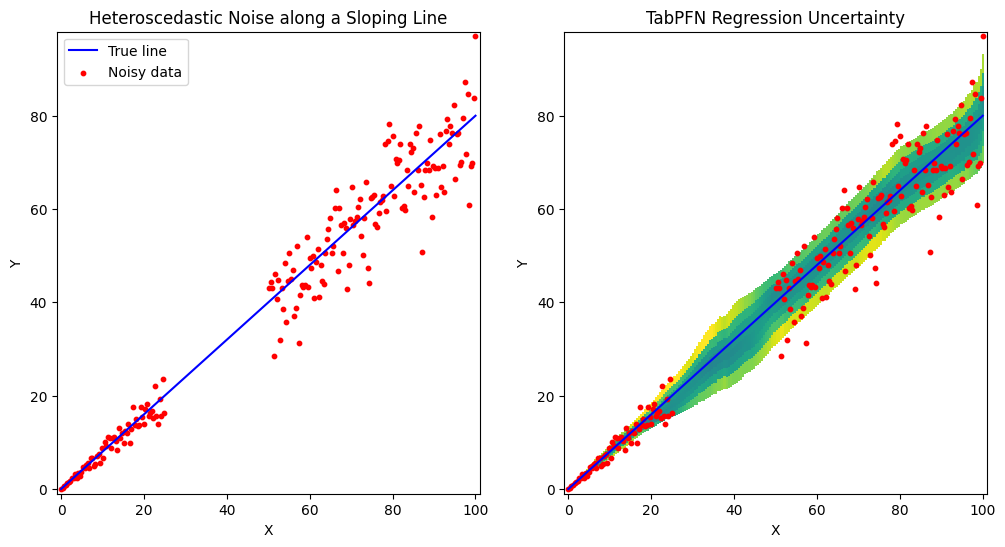

In [ ]:
fig = plt.figure(figsize=(12, 6))

# Plot the original data
ax = fig.add_subplot(121)
ax.plot(x, y_line, label="True line", color="blue")
ax.scatter(x, y_noisy, label="Noisy data", color="red", s=10)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_xlim(min(x) - 1, max(x) + 1)
ax.set_ylim(np.min(y_noisy) - 1, np.max(y_noisy) + 1)
ax.set_title("Heteroscedastic Noise along a Sloping Line")
ax.legend()

# plot the uncertainty estimates obtained from TabPFN
ax = fig.add_subplot(122)
plot_regression_uncertainty(ax, x, y_line, y_noisy, x_test, color_multiplier=5)

# Time Series Forecasting <a name="timeseries"></a>

TabPFN can be used for time series prediction, following the work of Hoo et al. (Zero-Shot Time Series Forecasting with TabPFNv2; https://arxiv.org/abs/2501.02945v3).

In this demo, we will use the time series dataset from [Chronos Dataset](https://huggingface.co/datasets/autogluon/chronos_datasets) on HuggingFace. Also, we'll keep it short and work with just 2 time series from the dataset.

Feel free to explore other datasets by using the dataset names from Chronos Dataset on HuggingFace or even use time series data of your own problem.


## *Installation*

In [ ]:
!uv pip install tabpfn-time-series
raise ValueError(
    "Make sure to restart the session before proceeding, otherwise errors will follow (Runtime > Restart Session)"
)

Using Python 3.11.13 environment at: /usr
Resolved 60 packages in 505ms
⠙ Preparing packages... (0/4)
⠙ Preparing packages... (0/4)
⠙ Preparing packages... (0/4)
⠙ Preparing packages... (0/4)
⠙ Preparing packages... (0/4)
⠙ Preparing packages... (0/4)
pandas     ------------------------------     0 B/11.67 MiB
⠙ Preparing packages... (0/4)
gluonts    ------------------------------     0 B/1.45 MiB
pandas     ------------------------------     0 B/11.67 MiB
⠙ Preparing packages... (0/4)
tabpfn-time-series ------------------------------     0 B/32.56 KiB
gluonts    ------------------------------     0 B/1.45 MiB
pandas     ------------------------------     0 B/11.67 MiB
⠙ Preparing packages... (0/4)
tabpfn-time-series ------------------------------     0 B/32.56 KiB
gluonts    ------------------------------ 16.00 KiB/1.45 MiB
pandas     ------------------------------     0 B/11.67 MiB
⠙ Preparing packages... (0/4)
tabpfn-time-series ------------------------------     0 B/32.56 KiB
gluon

## Load Time Series Data

In this demo, we will use the time series dataset from [Chronos Dataset](https://huggingface.co/datasets/autogluon/chronos_datasets) on HuggingFace. Also, we'll keep it short and work with just 2 time series from the dataset.

Feel free to explore other datasets by using the dataset names from Chronos Dataset on HuggingFace or even use time series data of your own problem.

In [ ]:
dataset_metadata = {
    "monash_tourism_monthly": {"prediction_length": 24},
    "m4_hourly": {"prediction_length": 48},
}

dataset_choice = "monash_tourism_monthly"
num_time_series_subset = 2

In [ ]:
from datasets import load_dataset
from tabpfn_time_series import TimeSeriesDataFrame
from tabpfn_time_series.data_preparation import generate_test_X, to_gluonts_univariate

prediction_length = dataset_metadata[dataset_choice]["prediction_length"]
dataset = load_dataset("autogluon/chronos_datasets", dataset_choice)

tsdf = TimeSeriesDataFrame(to_gluonts_univariate(dataset["train"]))
tsdf = tsdf[
    tsdf.index.get_level_values("item_id").isin(tsdf.item_ids[:num_time_series_subset])
]
train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(
    prediction_length=prediction_length
)
test_tsdf = generate_test_X(train_tsdf, prediction_length)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Let's take a look at the time series data.

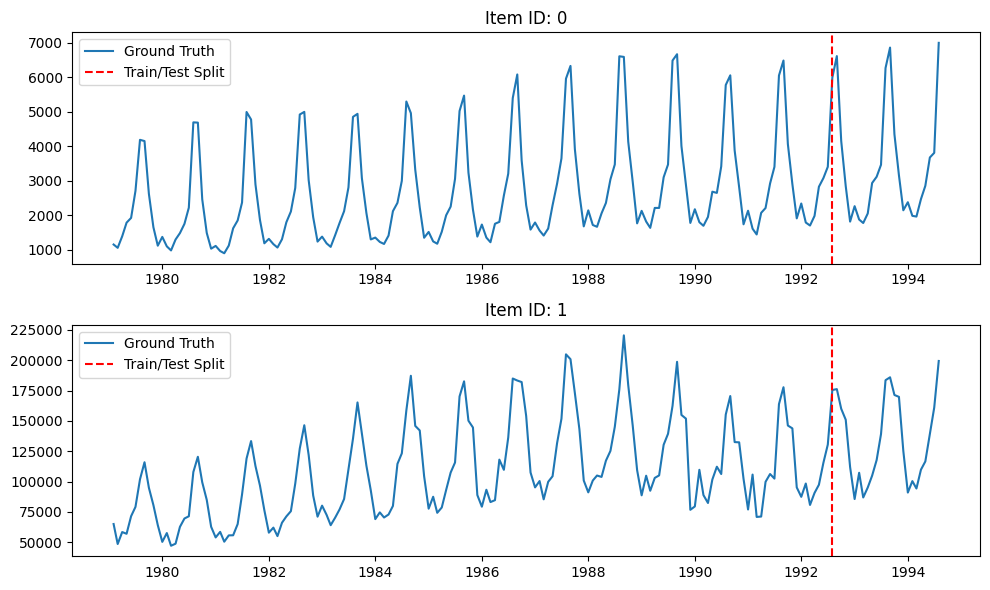

In [ ]:
from tabpfn_time_series.plot import plot_actual_ts

plot_actual_ts(train_tsdf, test_tsdf_ground_truth)

## Adding Features

In our paper, we propose adding `Running Index`, `Calendar Features`, and `Auto Seasonal Features` to the table.

**Feel free to experiment with your own features!**

To do that, simply define your own feature functions and pass them to the `FeatureTransformer`.

In [ ]:
from tabpfn_time_series import FeatureTransformer
from tabpfn_time_series.features import (
    AutoSeasonalFeature,
    CalendarFeature,
    RunningIndexFeature,
)

selected_features = [
    RunningIndexFeature(),
    CalendarFeature(),
    AutoSeasonalFeature(),
]

feature_transformer = FeatureTransformer(selected_features)

train_tsdf, test_tsdf = feature_transformer.transform(train_tsdf, test_tsdf)

Let's take a look at the tables (train and test) before we proceed to do predictions.

✅ Realize that we have added some features into the tables.

In [ ]:
train_tsdf.head()

target  running_index  year  second_of_minute_sin  \
item_id timestamp                                                          
0       1979-01-31  1149.8700              0  1979                   0.0   
        1979-02-28  1053.8002              1  1979                   0.0   
        1979-03-31  1388.8798              2  1979                   0.0   
        1979-04-30  1783.3702              3  1979                   0.0   
        1979-05-31  1921.0252              4  1979                   0.0   

                    second_of_minute_cos  minute_of_hour_sin  \
item_id timestamp                                              
0       1979-01-31                   1.0                 0.0   
        1979-02-28                   1.0                 0.0   
        1979-03-31                   1.0                 0.0   
        1979-04-30                   1.0                 0.0   
        1979-05-31                   1.0                 0.0   

                    minute_of_hour_cos  hour_of_day_sin  hour_of_day_cos  \
item_id timestamp                                                          
0       1979-01-31                 1.0              0.0              1.0   
        1979-02-28                 1.0              0.0              1.0   
        1979-03-31                 1.0              0.0              1.0   
        1979-04-30                 1.0              0.0              1.0   
        1979-05-31                 1.0              0.0              1.0   

                    day_of_week_sin  ...    sin_#0        cos_#0  \
item_id timestamp                    ...                           
0       1979-01-31     8.660254e-01  ...  0.000000  1.000000e+00   
        1979-02-28     8.660254e-01  ...  0.500000  8.660254e-01   
        1979-03-31    -8.660254e-01  ...  0.866025  5.000000e-01   
        1979-04-30     0.000000e+00  ...  1.000000  6.123234e-17   
        1979-05-31     1.224647e-16  ...  0.866025 -5.000000e-01   

                          sin_#1  cos_#1        sin_#2        cos_#2  \
item_id timestamp                                                      
0       1979-01-31  0.000000e+00     1.0  0.000000e+00  1.000000e+00   
        1979-02-28  8.660254e-01     0.5  1.000000e+00  6.123234e-17   
        1979-03-31  8.660254e-01    -0.5  1.224647e-16 -1.000000e+00   
        1979-04-30  1.224647e-16    -1.0 -1.000000e+00 -1.836970e-16   
        1979-05-31 -8.660254e-01    -0.5 -2.449294e-16  1.000000e+00   

                          sin_#3  cos_#3        sin_#4  cos_#4  
item_id timestamp                                               
0       1979-01-31  0.000000e+00     1.0  0.000000e+00     1.0  
        1979-02-28  1.224647e-16    -1.0  8.660254e-01    -0.5  
        1979-03-31 -2.449294e-16     1.0 -8.660254e-01    -0.5  
        1979-04-30  3.673940e-16    -1.0 -2.449294e-16     1.0  
        1979-05-31 -4.898587e-16     1.0  8.660254e-01    -0.5  

[5 rows x 29 columns]

In [ ]:
test_tsdf.head()

target  running_index  year  second_of_minute_sin  \
item_id timestamp                                                       
0       1992-08-31     NaN            163  1992                   0.0   
        1992-09-30     NaN            164  1992                   0.0   
        1992-10-31     NaN            165  1992                   0.0   
        1992-11-30     NaN            166  1992                   0.0   
        1992-12-31     NaN            167  1992                   0.0   

                    second_of_minute_cos  minute_of_hour_sin  \
item_id timestamp                                              
0       1992-08-31                   1.0                 0.0   
        1992-09-30                   1.0                 0.0   
        1992-10-31                   1.0                 0.0   
        1992-11-30                   1.0                 0.0   
        1992-12-31                   1.0                 0.0   

                    minute_of_hour_cos  hour_of_day_sin  hour_of_day_cos  \
item_id timestamp                                                          
0       1992-08-31                 1.0              0.0              1.0   
        1992-09-30                 1.0              0.0              1.0   
        1992-10-31                 1.0              0.0              1.0   
        1992-11-30                 1.0              0.0              1.0   
        1992-12-31                 1.0              0.0              1.0   

                    day_of_week_sin  ...    sin_#0        cos_#0  \
item_id timestamp                    ...                           
0       1992-08-31     0.000000e+00  ... -0.500000 -8.660254e-01   
        1992-09-30     8.660254e-01  ... -0.866025 -5.000000e-01   
        1992-10-31    -8.660254e-01  ... -1.000000 -1.224956e-14   
        1992-11-30     0.000000e+00  ... -0.866025  5.000000e-01   
        1992-12-31     1.224647e-16  ... -0.500000  8.660254e-01   

                          sin_#1  cos_#1        sin_#2        cos_#2  \
item_id timestamp                                                      
0       1992-08-31  8.660254e-01     0.5 -1.000000e+00 -2.596808e-14   
        1992-09-30  8.660254e-01    -0.5 -3.135839e-14  1.000000e+00   
        1992-10-31  2.449913e-14    -1.0  1.000000e+00  3.674869e-14   
        1992-11-30 -8.660254e-01    -0.5 -1.470443e-14 -1.000000e+00   
        1992-12-31 -8.660254e-01     0.5 -1.000000e+00  9.314124e-15   

                          sin_#3  cos_#3        sin_#4  cos_#4  
item_id timestamp                                               
0       1992-08-31  5.193617e-14    -1.0  8.660254e-01    -0.5  
        1992-09-30 -6.271677e-14     1.0 -8.660254e-01    -0.5  
        1992-10-31  7.349738e-14    -1.0 -4.899825e-14     1.0  
        1992-11-30  2.940885e-14     1.0  8.660254e-01    -0.5  
        1992-12-31 -1.862825e-14    -1.0 -8.660254e-01    -0.5  

[5 rows x 29 columns]

## Prediction

Now, let's perform prediction.

We provide two options, `TabPFNMode.LOCAL` and `TabPFNMode.CLIENT`, as the backend for TabPFN.

- `TabPFNMode.LOCAL` uses your local machine to run TabPFN.
- `TabPFNMode.CLIENT` uses TabPFN's inference service provided by [tabpfn-client](https://github.com/automl/tabpfn-client)

For this demo, we'll use `TabPFNMode.CLIENT` to perform prediction. If you have not use the client before, you'll be prompted to create an account.

Note: if your machine doesn't have a GPU, using `TabPFNMode.CLIENT` is recommended -- must faster 😉.


In [ ]:
from tabpfn_time_series import TabPFNMode, TabPFNTimeSeriesPredictor

predictor = TabPFNTimeSeriesPredictor(
    tabpfn_mode=TabPFNMode.LOCAL,  # adapt this to TabPFNMode.CLIENT if using API
)

pred = predictor.predict(train_tsdf, test_tsdf)

tabpfn-v2-regressor-2noar4o2.ckpt:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

## Visualize the Results

Let's visualize the forecasting results.

Also, note that we provide both **point prediction** and **quantile prediction**, how amazing! 😄

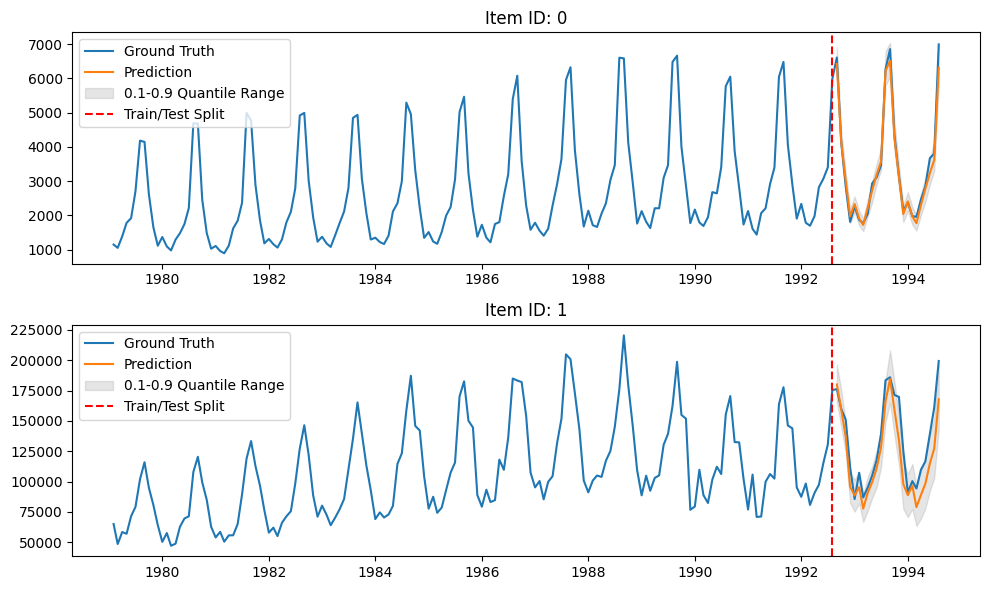

In [ ]:
from tabpfn_time_series.plot import plot_pred_and_actual_ts

plot_pred_and_actual_ts(
    train=train_tsdf,
    test=test_tsdf_ground_truth,
    pred=pred,
)

In [ ]:
pred.head()

target          0.1          0.2          0.3  \
item_id timestamp                                                        
0       1992-08-31  6426.939453  6031.653320  6178.973145  6275.490234   
        1992-09-30  4145.877441  3876.051514  3968.562012  4035.613037   
        1992-10-31  3011.042725  2784.187012  2865.281006  2921.160889   
        1992-11-30  1973.286865  1771.009521  1840.910278  1890.718872   
        1992-12-31  2334.358643  2097.147949  2181.239014  2240.146484   

                            0.4          0.5          0.6          0.7  \
item_id timestamp                                                        
0       1992-08-31  6353.638184  6426.939453  6504.241699  6594.743652   
        1992-09-30  4092.619629  4145.877441  4200.451172  4261.462402   
        1992-10-31  2967.819336  3011.042725  3053.839844  3101.681396   
        1992-11-30  1933.383545  1973.286865  2014.023560  2059.214111   
        1992-12-31  2289.293945  2334.358643  2378.629883  2425.561279   

                            0.8          0.9  
item_id timestamp                             
0       1992-08-31  6715.722168  6915.344238  
        1992-09-30  4340.528809  4468.440918  
        1992-10-31  3160.598389  3250.026367  
        1992-11-30  2114.486328  2196.697754  
        1992-12-31  2480.219238  2554.438477

# Using TabPFN as a Base Model for Causal Inference <a name="causal"></a>

Often decisions hinge on **what changes because of an action**, not just what correlates with it. Causal effect estimation turns data into these counterfactual answers—e.g., _If we treat someone like xxx, how much does the expected outcome change?_

Below we show how to use TabPFN to estimation the effect of these causal intervations.

*In depth explanation:*

To estimate it most methods build two ingredients: an **outcome model** (predict yyy under T\=1T{=}1T\=1 and T\=0T{=}0T\=0) and often a **propensity model** (estimate Pr⁡(T\=1∣X)\\Pr(T{=}1\\mid X)Pr(T\=1∣X)) to reduce selection bias. You can treat this as AutoML, or take a strong default: **TabPFN**, a pretrained transformer for tabular data that frequently works **out of the box** as the base learner inside CATE pipelines—cutting tuning time while staying competitive.


Many causal inference methods require selection of base models to fit either propensity or outcome models. While recent studies have framed this as an AutoML model selection problem ([Vandershueren et al, 2025](https://openreview.net/forum?id=QbOoz74GNO)), other studies ([Zhang et al, 2025](https://arxiv.org/pdf/2505.20003)) have shown TabPFN to be a strong choice "out of the box" in various CATE estimation methods. In parallel, there is a growing body of research pre-training PFNs specifically for the conditional average treatment effect (CATE) estimation task ([Robertson et al.](https://arxiv.org/pdf/2506.06039)), defined as:

$$CATE : \tau = E[y | do(1), x] - E[y | do(0), x]$$


**NOTE:** Current CATE estimators only work when *unconfoundedness* $(Y_0, Y_1) \perp \kern-1.8ex \perp T$ $|$ $X$ is satisfied. We are working on pre-training a foundation model called "Do-PFN" ([Robertson et al.](https://arxiv.org/pdf/2506.06039)) that is designed to offer strong out-of-the box performance in **all** identifiable scenarios (including front-door and instrumental variable settings).

### 1) Install the required packages

Note: you will need to restart the notebook (Runtime -> Restart Session)





In [ ]:
!pip install tabpfn
!pip install econml


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.7/173.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.3/137.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 23.6 MB/s eta 0:00:00


### 2) Generate a synthetic CATE dataset

The dataset $D = (T, X, Y, \tau)$ below represents an observed confounder scenario $G = \{X \rightarrow Y, T \rightarrow Y, X \rightarrow T\}$ and thus satisfies the unconfoundedness assumption: $(Y_0, Y_1) \perp \kern-1.8ex \perp T$ $|$ $X$. We divide the dataset into train and test splits $(D_{train}, D_{test})$.

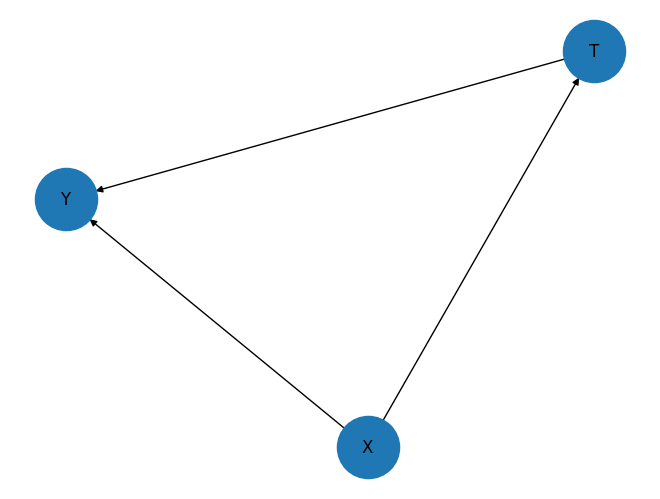

In [ ]:
import networkx as nx

edges = [["X", "Y"], ["T", "Y"], ["X", "T"]]
graph = nx.DiGraph(edges)
nx.draw(graph, with_labels=True, node_size=2000)

In [ ]:
import numpy as np

num_samples, num_features, train_test_split = 500, 5, 75

noise_scale = 0.01
exogenous_scale = 0.1
heterogeneity_scale = 2

X = np.random.normal(loc=0, scale=exogenous_scale, size=(num_samples, num_features)).astype(np.float32)
prop_eps = np.random.normal(loc=0, scale=noise_scale, size=(num_samples)).astype(np.float32)
Y_eps = np.random.normal(loc=0, scale=noise_scale, size=(num_samples)).astype(np.float32)

w_X_Y = np.random.uniform(size=num_features)
w_X_T = np.random.uniform(size=num_features)
w_X_T_effect = np.random.uniform(size=num_features)

T_0 = np.zeros(shape=num_samples).astype(np.float32)
T_1 = np.ones(shape=num_samples).astype(np.float32)

base_X_Y = np.sum(w_X_Y * X, axis=1)
base_X_T = np.sum(w_X_T * X, axis=1)
heterogeneity_term = np.sum(w_X_T_effect * X, axis=1)

propensity = np.sin(base_X_T) + prop_eps
T = (propensity > propensity.mean()).astype(np.float32)

Y_0 = np.cos(base_X_Y) + np.sin(0.3 * T_0) + Y_eps
Y_1 = np.cos(base_X_Y) + np.sin(0.3 * T_1 + heterogeneity_scale * heterogeneity_term) + Y_eps

Y = Y_0 * (1 - T) + Y_1 * T
tau = Y_1 - Y_0

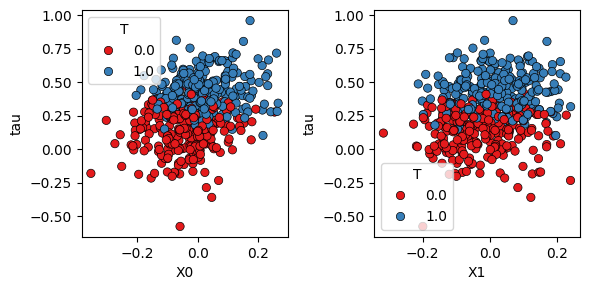

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({**{f"X{i}": X[:, i] for i in range(num_features)}, "T": T, "Y": Y, "Y_0": Y_0, "Y_1": Y_1, "tau": tau})
fig, axes = plt.subplots(ncols=2, figsize=(6, 3))
sns.scatterplot(data=df, x="X0", y="tau", hue="T", ax=axes[0], edgecolor="black", palette="Set1")
sns.scatterplot(data=df, x="X1", y="tau", hue="T", ax=axes[1], edgecolor="black", palette="Set1")
fig.tight_layout()

In [ ]:
perm = np.random.permutation(num_samples)
train_idx, test_idx = perm[:train_test_split], perm[train_test_split:]
X_train, X_test = X[train_idx], X[test_idx]
Y_train, Y_test = Y[train_idx], Y[test_idx]
T_train, T_test = T[train_idx], T[test_idx]
tau_test = tau[test_idx]

### Run CATE estimators with TabPFN as a base model

We fit three CATE estimators to our synthetic datasets with different choices of base models



*   `s_tabpfn`: TabPFN applied as an `SLearner`
*   `cfdml_tabpfn`: TabPFN applied as a propensity and outcome in `CausalForestDML`
*   `cfdml_default`: `CausalForestDML` with default propensity and outcome models



In [ ]:
from econml.metalearners import SLearner
from econml.dml import CausalForestDML
from tabpfn import TabPFNClassifier, TabPFNRegressor

In [ ]:
s_tabpfn = SLearner(overall_model=TabPFNRegressor())

s_tabpfn.fit(Y=Y_train, X=X_train, T=T_train)
s_tabpfn_cate = s_tabpfn.effect(X=X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
cfdml_tabpfn = CausalForestDML(model_y=TabPFNRegressor(), model_t=TabPFNClassifier(), discrete_treatment=True)

cfdml_tabpfn.fit(Y=Y_train, X=X_train, T=T_train)
cfdml_tabpfn_cate = cfdml_tabpfn.effect(X=X_test)

In [ ]:
cfdml_default = CausalForestDML(discrete_treatment=True)

cfdml_default.fit(Y=Y_train, X=X_train, T=T_train)
cfdml_default_cate = cfdml_default.effect(X=X_test)

### Evaluate performance in CATE estimation

We assess how close our predicted individual effects $\hat{\tau}(x)$ are to the true effects $\tau(x)$ using **PEHE** (Precision in Estimation of Heterogeneous Effects).
PEHE is defined as the root-mean-squared-error (RMSE) between predicted and ground truth CATE values.

$$\text{PEHE} = \sqrt{\frac{1}{n} \sum [\widehat{\tau}(x_i) - \tau(x_i) ]^2}$$


In [ ]:
from sklearn.metrics import root_mean_squared_error

s_tabpfn_pehe = root_mean_squared_error(tau_test, s_tabpfn_cate)
cfdml_tabpfn_pehe = root_mean_squared_error(tau_test, cfdml_tabpfn_cate)
cfdml_default_pehe = root_mean_squared_error(tau_test, cfdml_default_cate)

print(f"s_tabpfn PEHE: {s_tabpfn_pehe}")
print(f"cfdml_tabpfn PEHE: {cfdml_tabpfn_pehe}")
print(f"cfdml_default PEHE: {cfdml_default_pehe}")

s_tabpfn PEHE: 0.08713507363096516
cfdml_tabpfn PEHE: 0.20052572664791984
cfdml_default PEHE: 0.21899401692453999


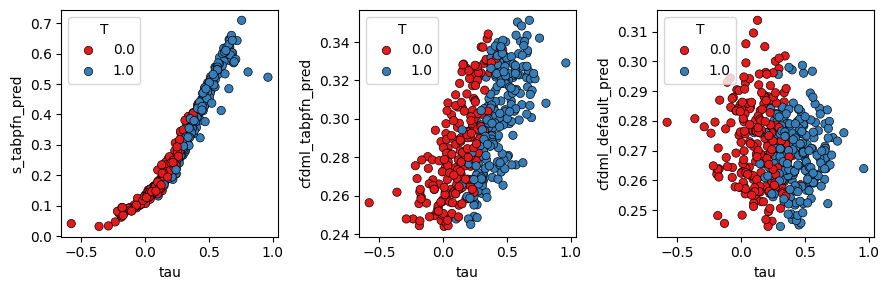

In [ ]:
df_test = pd.DataFrame({"T": T_test, "Y": Y_test, "tau": tau_test, **{f"X{i}": X_test[:, i] for i in range(num_features)}})
df_test["s_tabpfn_pred"], df_test["cfdml_tabpfn_pred"], df_test["cfdml_default_pred"] = s_tabpfn_cate, cfdml_tabpfn_cate, cfdml_default_cate

fig, axes = plt.subplots(ncols=3, figsize=(9, 3))
sns.scatterplot(data=df_test, x="tau", y="s_tabpfn_pred", hue="T", ax=axes[0], edgecolor="black", palette="Set1")
sns.scatterplot(data=df_test, x="tau", y="cfdml_tabpfn_pred", hue="T", ax=axes[1], edgecolor="black", palette="Set1")
sns.scatterplot(data=df_test, x="tau", y="cfdml_default_pred", hue="T", ax=axes[2], edgecolor="black", palette="Set1")
fig.tight_layout()

# Feedback

Let us know what you think!

Write us at Discord: https://discord.gg/qK7AaXPN or just simply create an issue on [GitHub](https://github.com/PriorLabs/tabpfn).

Thank you for trying out our method! 🎉
